In [1]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nnx
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
gpax.utils.enable_x64()

from utils.helper_functions import *

import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr


In [6]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df.head()

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,OCC(C#C)C#CC#C,-0.1353,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,1,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,OC1C2NC1(C#C)C2O,-1.9344,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,0,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,C1C2C3CC(CCO3)N12,0.2318,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,0,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,CC1=CC2CC(O2)C1O,0.4647,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,0,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,CC1CC1(O)CCC=O,0.7364,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,3,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994


## Training Stage

In [7]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(5000, 567)


In [8]:
#Different targets
targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

In [9]:
X1 = np.copy(X)
X1 = X1[:1000]
## Target: ringct
targets1 = targets1[:1000]

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()

dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)
loss = dkl_1.loss

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|███████████████████████████████████████████████████| 1000/1000 [03:11<00:00,  5.22it/s, init loss: 41045.4279, avg. loss [951-1000]: 36884.9448]



Inferred GP kernel parameters
k_length         [1.3033 1.0485]
k_scale          4.1401
noise            0.0165


In [10]:
# Getting the MLP and kernel params to reinitialize the model
nn, kernel = dkl_1.get_samples() # Returns the kernel and nn parameters
kernel 

{'k_length': Array([1.3032896 , 1.04847207], dtype=float64),
 'k_scale': Array(4.14014159, dtype=float64),
 'noise': Array(0.01645812, dtype=float64)}

## Prediction

In [11]:
batch_size_reconstruct = 250
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

##  Active Learning

In [13]:
X1 = np.copy(X)
X1 = X1[:1000]
#target
targets1 = - df['enthalpy'].values

targets1 = targets1[:1000]
target_property = "enthalpy"

#Active learning setup parameters
init_num = 50
exp_step = 50
batch_size_learn = 50 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]

y1_train = targets1[idx1]
y1_unmeasured = np.delete(targets1, idx1, axis=0)

indices_unmeasured_1 = np.delete(indices_total_1, idx1)

Acquistion Function : PI 
______________________________

Step 1


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.51it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55793.7187]



Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.38it/s, init loss: 1223933.8427, avg. loss [951-1000]: 55862.4242]



Inferred GP kernel parameters
k_length         [1.4215 0.9637]
k_scale          6.2183
noise            2.37
Train Loss: 164.05522684072332
Test Loss: 41728.79468048655
Pearson Coeff: -0.07869751154459373

Step 3


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.11it/s, init loss: 1228989.1765, avg. loss [951-1000]: 56023.3103]



Inferred GP kernel parameters
k_length         [1.4099 0.9605]
k_scale          6.1764
noise            2.4084000000000003
Train Loss: 160.87014776647447
Test Loss: 47240.21734351788
Pearson Coeff: -0.05931553855999882

Step 4


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.64it/s, init loss: 1235453.3701, avg. loss [951-1000]: 56035.9516]



Inferred GP kernel parameters
k_length         [1.4089 0.9787]
k_scale          6.1421
noise            2.3896
Train Loss: 145.82226631194257
Test Loss: 41626.51524014757
Pearson Coeff: -0.07008385805334422

Step 5


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.09it/s, init loss: 1244283.7049, avg. loss [951-1000]: 56127.8925]



Inferred GP kernel parameters
k_length         [1.4071 0.9813]
k_scale          6.115600000000001
noise            2.4214
Train Loss: 158.314854970013
Test Loss: 43435.62438760357
Pearson Coeff: -0.06358259478901969

Step 6


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 406.01it/s, init loss: 1246701.8965, avg. loss [951-1000]: 56555.9914]



Inferred GP kernel parameters
k_length         [1.4274 0.9854]
k_scale          6.1029
noise            2.4453
Train Loss: 141.6552936488411
Test Loss: 42598.61824584961
Pearson Coeff: -0.07122775384551094

Step 7


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.74it/s, init loss: 1252893.2219, avg. loss [951-1000]: 56208.9845]



Inferred GP kernel parameters
k_length         [1.4098 0.9747]
k_scale          6.074800000000001
noise            2.3897
Train Loss: 149.63347220328
Test Loss: 41909.89754987296
Pearson Coeff: -0.07946021923409045

Step 8


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.81it/s, init loss: 1255742.7181, avg. loss [951-1000]: 56384.8554]



Inferred GP kernel parameters
k_length         [1.4113 0.9748]
k_scale          6.0547
noise            2.3906
Train Loss: 146.50860506264786
Test Loss: 40209.41780492991
Pearson Coeff: -0.05983775302345609

Step 9


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.89it/s, init loss: 1260290.9680, avg. loss [951-1000]: 56346.9661]



Inferred GP kernel parameters
k_length         [1.4065 0.96  ]
k_scale          6.046200000000001
noise            2.408
Train Loss: 140.94007513944038
Test Loss: 42462.24761638265
Pearson Coeff: -0.0518430021673077

Step 10


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.58it/s, init loss: 1260513.7428, avg. loss [951-1000]: 56210.5671]



Inferred GP kernel parameters
k_length         [1.4096 0.987 ]
k_scale          6.054200000000001
noise            2.4121
Train Loss: 133.3887563080768
Test Loss: 40405.880926850215
Pearson Coeff: -0.053769889924401584

Step 11


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.08it/s, init loss: 1272677.6859, avg. loss [951-1000]: 56425.4424]



Inferred GP kernel parameters
k_length         [1.3909 0.9725]
k_scale          6.0074000000000005
noise            2.4016
Train Loss: 142.21668917394078
Test Loss: 42629.71807368835
Pearson Coeff: -0.057673947447984895

Step 12


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 366.48it/s, init loss: 1274131.4354, avg. loss [951-1000]: 56511.0359]



Inferred GP kernel parameters
k_length         [1.4076 0.9327]
k_scale          5.994400000000001
noise            2.4183
Train Loss: 149.34729221110112
Test Loss: 47325.75564677437
Pearson Coeff: -0.053585577187369046

Step 13


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 344.90it/s, init loss: 1276710.1026, avg. loss [951-1000]: 56489.4904]



Inferred GP kernel parameters
k_length         [1.3949 0.9878]
k_scale          5.9962
noise            2.4046000000000003
Train Loss: 143.22834828373487
Test Loss: 41373.352458872876
Pearson Coeff: -0.043485194359291296

Step 14


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 292.24it/s, init loss: 1279429.5957, avg. loss [951-1000]: 56472.1957]



Inferred GP kernel parameters
k_length         [1.3995 0.9803]
k_scale          5.997400000000001
noise            2.406
Train Loss: 132.3194783373258
Test Loss: 42769.243374722595
Pearson Coeff: -0.08968282352071051

Step 15


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 268.37it/s, init loss: 1283498.3596, avg. loss [951-1000]: 56689.1218]



Inferred GP kernel parameters
k_length         [1.4051 0.9425]
k_scale          5.9375
noise            2.4553000000000003
Train Loss: 141.0781768781349
Test Loss: 48031.26132810508
Pearson Coeff: -0.08798341812236442

Step 16


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.36it/s, init loss: 1287861.0833, avg. loss [951-1000]: 56690.4258]



Inferred GP kernel parameters
k_length         [1.4069 0.9509]
k_scale          5.915500000000001
noise            2.4301
Train Loss: 130.69550629269605
Test Loss: 44336.750443095414
Pearson Coeff: -0.0712587324636636

Step 17


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.35it/s, init loss: 1291330.7114, avg. loss [951-1000]: 56747.4424]



Inferred GP kernel parameters
k_length         [1.4027 0.9667]
k_scale          5.931500000000001
noise            2.4179
Train Loss: 128.7672055978831
Test Loss: 43818.47918456364
Pearson Coeff: -0.09384105676131714

Step 18


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.59it/s, init loss: 1291810.5497, avg. loss [951-1000]: 56688.9415]



Inferred GP kernel parameters
k_length         [1.4186 0.9624]
k_scale          5.9187
noise            2.4401
Train Loss: 115.44404672102895
Test Loss: 39471.46441423464
Pearson Coeff: -0.09464539842588203

Step 19


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.85it/s, init loss: 1292440.5907, avg. loss [951-1000]: 56791.7574]



Inferred GP kernel parameters
k_length         [1.4105 0.9766]
k_scale          5.9249
noise            2.4306
Train Loss: 117.3850992483425
Test Loss: 40857.435448300224
Pearson Coeff: -0.0761857396868028

Step 20


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.92it/s, init loss: 1299990.4130, avg. loss [951-1000]: 57043.9524]



Inferred GP kernel parameters
k_length         [1.402 0.954]
k_scale          5.8498
noise            2.4503
Train Loss: 112.96628974860914
Test Loss: 46627.819826946725
Pearson Coeff: -0.13091701544484866

Step 21


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.97it/s, init loss: 1300719.8184, avg. loss [951-1000]: 57069.6654]



Inferred GP kernel parameters
k_length         [1.4096 0.9601]
k_scale          5.837400000000001
noise            2.4513000000000003
Train Loss: 111.73091505684269
Test Loss: 39383.21581223503
Pearson Coeff: -0.05993268743493648

Step 22


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.11it/s, init loss: 1311660.9797, avg. loss [951-1000]: 57035.6383]



Inferred GP kernel parameters
k_length         [1.4096 0.9587]
k_scale          5.8623
noise            2.4673000000000003
Train Loss: 169.63080873360897
Test Loss: 39920.3551571604
Pearson Coeff: -0.08056296809974722

Step 23


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.18it/s, init loss: 1325261.5730, avg. loss [951-1000]: 57105.0845]



Inferred GP kernel parameters
k_length         [1.4133 0.9539]
k_scale          5.8161000000000005
noise            2.4567
Train Loss: 111.57378485861591
Test Loss: 41392.12879791059
Pearson Coeff: -0.07272111901849614

Step 24


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.01it/s, init loss: 1327579.5017, avg. loss [951-1000]: 57138.8527]



Inferred GP kernel parameters
k_length         [1.4072 0.9765]
k_scale          5.8044
noise            2.459
Train Loss: 109.10693859100763
Test Loss: 35405.90698889122
Pearson Coeff: -0.0651106824927905

Step 25


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.98it/s, init loss: 1336622.4755, avg. loss [951-1000]: 57207.2229]



Inferred GP kernel parameters
k_length         [1.4003 0.9599]
k_scale          5.794700000000001
noise            2.4601
Train Loss: 123.60121580607405
Test Loss: 38972.49363549458
Pearson Coeff: -0.05917889776878809

Step 26


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.66it/s, init loss: 1378887.1773, avg. loss [951-1000]: 57582.9549]



Inferred GP kernel parameters
k_length         [1.4133 0.9838]
k_scale          5.6782
noise            2.3810000000000002
Train Loss: 102.05360478294314
Test Loss: 31836.117999603335
Pearson Coeff: -0.08446531224882853

Step 27


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 259.34it/s, init loss: 1379869.4304, avg. loss [951-1000]: 57658.1157]



Inferred GP kernel parameters
k_length         [1.4052 0.9714]
k_scale          5.6763
noise            2.3741000000000003
Train Loss: 125.22435181439663
Test Loss: 35131.00397912584
Pearson Coeff: -0.09744116895398755

Step 28


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.03it/s, init loss: 1400920.4048, avg. loss [951-1000]: 57669.6659]



Inferred GP kernel parameters
k_length         [1.4088 0.96  ]
k_scale          5.652
noise            2.4052000000000002
Train Loss: 117.7082817846991
Test Loss: 33457.162168891184
Pearson Coeff: -0.04671944755433495

Step 29


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.27it/s, init loss: 1404486.0898, avg. loss [951-1000]: 57727.4663]



Inferred GP kernel parameters
k_length         [1.416  0.9493]
k_scale          5.6437
noise            2.4164000000000003
Train Loss: 103.87775032856187
Test Loss: 36274.42334748489
Pearson Coeff: -0.044812069497924864

Step 30


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.12it/s, init loss: 1454169.4924, avg. loss [951-1000]: 58604.4098]



Inferred GP kernel parameters
k_length         [1.4011 0.9571]
k_scale          5.478400000000001
noise            2.7273
Train Loss: 139.04824660211617
Test Loss: 37575.63791500641
Pearson Coeff: -0.05391195013370721

Step 31


100%|████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 138.74it/s, init loss: 1459123.6871, avg. loss [951-1000]: 58853.8155]



Inferred GP kernel parameters
k_length         [1.4303 0.9653]
k_scale          5.4692
noise            2.8372
Train Loss: 122.47773989850327
Test Loss: 33355.31438777008
Pearson Coeff: -0.06202899931832779

Step 32


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.65it/s, init loss: 1469386.0235, avg. loss [951-1000]: 58762.8007]



Inferred GP kernel parameters
k_length         [1.4183 0.9487]
k_scale          5.49
noise            2.7578
Train Loss: 130.9675170974702
Test Loss: 36591.81049011922
Pearson Coeff: -0.0509011937275549

Step 33


100%|████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 116.35it/s, init loss: 1488291.2466, avg. loss [951-1000]: 58966.0417]



Inferred GP kernel parameters
k_length         [1.4216 0.9532]
k_scale          5.4766
noise            2.6557
Train Loss: 115.92831996285052
Test Loss: 36540.09183602366
Pearson Coeff: -0.07379858466116367

Step 34


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.82it/s, init loss: 1498068.2258, avg. loss [951-1000]: 58991.0327]



Inferred GP kernel parameters
k_length         [1.4262 0.9436]
k_scale          5.5051000000000005
noise            2.5833
Train Loss: 123.25483237340099
Test Loss: 39931.850522502675
Pearson Coeff: -0.06720125847554397

Step 35


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.85it/s, init loss: 1498661.4186, avg. loss [951-1000]: 58927.3040]



Inferred GP kernel parameters
k_length         [1.4229 0.9542]
k_scale          5.506600000000001
noise            2.6024000000000003
Train Loss: 107.16641611387566
Test Loss: 33295.86369798591
Pearson Coeff: -0.07977125445199107

Step 36


100%|████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.27it/s, init loss: 1501698.7301, avg. loss [951-1000]: 59012.3889]



Inferred GP kernel parameters
k_length         [1.435  0.9423]
k_scale          5.522600000000001
noise            2.5602
Train Loss: 118.095327668321
Test Loss: 34989.88599598739
Pearson Coeff: -0.06045283274192915

Step 37


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.80it/s, init loss: 1505352.1382, avg. loss [951-1000]: 59026.4469]



Inferred GP kernel parameters
k_length         [1.4163 0.9496]
k_scale          5.4874
noise            2.668
Train Loss: 125.1708913971086
Test Loss: 37252.083541451466
Pearson Coeff: -0.06987466244229475

Step 38


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.38it/s, init loss: 1506130.0828, avg. loss [951-1000]: 59062.9839]



Inferred GP kernel parameters
k_length         [1.4321 0.9599]
k_scale          5.4923
noise            2.5996
Train Loss: 111.27700715092095
Test Loss: 36933.360226602286
Pearson Coeff: -0.10010079761476307

Step 39


100%|████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.63it/s, init loss: 1512748.9640, avg. loss [951-1000]: 59050.1093]



Inferred GP kernel parameters
k_length         [1.4203 0.9437]
k_scale          5.4878
noise            2.646
Train Loss: 108.84780782678308
Test Loss: 35143.038880086744
Pearson Coeff: -0.07707917583975034

Step 40


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.37it/s, init loss: 1542818.5321, avg. loss [951-1000]: 59898.6105]



Inferred GP kernel parameters
k_length         [1.422  0.9508]
k_scale          5.4316
noise            2.8274000000000004
Train Loss: 144.775305272605
Test Loss: 36659.42826625492
Pearson Coeff: -0.07671339891812555

Step 41


100%|████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.54it/s, init loss: 1543343.6523, avg. loss [951-1000]: 59223.4649]



Inferred GP kernel parameters
k_length         [1.4172 0.9381]
k_scale          5.4218
noise            2.8383000000000003
Train Loss: 123.25146635248286
Test Loss: 37769.88657923568
Pearson Coeff: -0.08407195418008802

Step 42


100%|█████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.11it/s, init loss: 1546528.5030, avg. loss [951-1000]: 59205.1815]



Inferred GP kernel parameters
k_length         [1.4013 0.9629]
k_scale          5.4268
noise            2.8263000000000003
Train Loss: 125.32424199675467
Test Loss: 33816.018371809565
Pearson Coeff: -0.04864030133970745

Step 43


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.96it/s, init loss: 1547495.6295, avg. loss [951-1000]: 59272.1237]



Inferred GP kernel parameters
k_length         [1.4122 0.9707]
k_scale          5.4434000000000005
noise            2.6385
Train Loss: 98.07834448871508
Test Loss: 30364.15654091943
Pearson Coeff: -0.07297630306612647

Step 44


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.12it/s, init loss: 1549287.7683, avg. loss [951-1000]: 59297.6603]



Inferred GP kernel parameters
k_length         [1.4133 0.9416]
k_scale          5.4008
noise            2.8595
Train Loss: 112.22051985067887
Test Loss: 36054.77610858561
Pearson Coeff: -0.04810587052614042

Step 45


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.29it/s, init loss: 1551920.9910, avg. loss [951-1000]: 59222.1384]



Inferred GP kernel parameters
k_length         [1.4166 0.9509]
k_scale          5.4077
noise            2.8221000000000003
Train Loss: 105.77607845140082
Test Loss: 32780.99232571477
Pearson Coeff: -0.082554468096872

Step 46


100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.93it/s, init loss: 1557670.5538, avg. loss [951-1000]: 58705.4505]



Inferred GP kernel parameters
k_length         [1.3651 0.926 ]
k_scale          5.4364
noise            3.7017
Train Loss: 127.6715558755089
Test Loss: 42583.66271152266
Pearson Coeff: -0.057097497567241126

Step 47


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.15it/s, init loss: 1578482.3943, avg. loss [951-1000]: 59463.6105]



Inferred GP kernel parameters
k_length         [1.4108 0.935 ]
k_scale          5.356800000000001
noise            2.9704
Train Loss: 149.19726001902225
Test Loss: 36972.77282453793
Pearson Coeff: -0.07757515589273724

Step 48


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.56it/s, init loss: 1596621.1279, avg. loss [951-1000]: 59573.7545]



Inferred GP kernel parameters
k_length         [1.4251 0.9416]
k_scale          5.382000000000001
noise            2.5447
Train Loss: 95.11852177644093
Test Loss: 33897.44593295894
Pearson Coeff: -0.04678954954339735

Step 49


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.87it/s, init loss: 1605489.1281, avg. loss [951-1000]: 59577.1654]



Inferred GP kernel parameters
k_length         [1.4246 0.9593]
k_scale          5.3609
noise            2.5735
Train Loss: 98.52663372332178
Test Loss: 31231.29484981027
Pearson Coeff: -0.0394870534537518

Step 50


100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 165.59it/s, init loss: 1611639.2183, avg. loss [951-1000]: 59729.5154]



Inferred GP kernel parameters
k_length         [1.4367 0.9523]
k_scale          5.3569
noise            2.5783
Train Loss: 97.18402460251606
Test Loss: 33390.35495732728
Pearson Coeff: -0.055842496480190885
Target Property : Enthalpy
Acquisition Function : PI


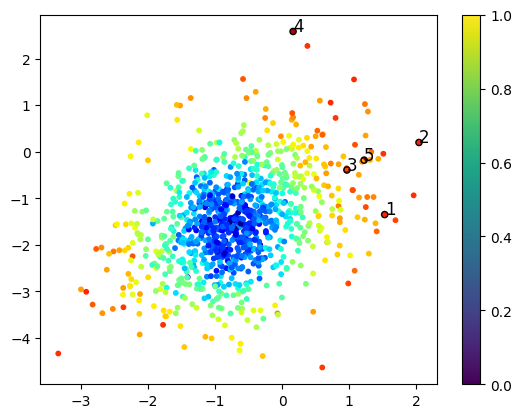

Acquistion Function : EI 
______________________________

Step 1


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.93it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55793.7187]



Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 435.17it/s, init loss: 1219386.7387, avg. loss [951-1000]: 55800.0238]



Inferred GP kernel parameters
k_length         [1.4061 0.9697]
k_scale          6.236400000000001
noise            2.3471
Train Loss: 153.49269826402957
Test Loss: 41750.13571350207
Pearson Coeff: -0.06042766600153737

Step 3


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 437.01it/s, init loss: 1220754.4629, avg. loss [951-1000]: 55812.2648]



Inferred GP kernel parameters
k_length         [1.4018 0.9692]
k_scale          6.2302
noise            2.3539000000000003
Train Loss: 153.57200715493107
Test Loss: 45518.706952321896
Pearson Coeff: -0.07719724237115615

Step 4


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.40it/s, init loss: 1223580.4929, avg. loss [951-1000]: 55836.1565]



Inferred GP kernel parameters
k_length         [1.4208 0.9787]
k_scale          6.201300000000001
noise            2.3718
Train Loss: 144.77097606081918
Test Loss: 42331.89110921191
Pearson Coeff: -0.06740486787257778

Step 5


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.52it/s, init loss: 1229329.7420, avg. loss [951-1000]: 55966.8415]



Inferred GP kernel parameters
k_length         [1.4208 0.9574]
k_scale          6.1771
noise            2.3669000000000002
Train Loss: 141.6075575433065
Test Loss: 42550.4609715723
Pearson Coeff: -0.05811267068839224

Step 6


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.23it/s, init loss: 1234676.2206, avg. loss [951-1000]: 56030.6125]



Inferred GP kernel parameters
k_length         [1.4111 0.971 ]
k_scale          6.1713000000000005
noise            2.3664
Train Loss: 157.1793748750653
Test Loss: 43325.91347129517
Pearson Coeff: -0.06198756916310766

Step 7


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.46it/s, init loss: 1239720.7219, avg. loss [951-1000]: 56060.2322]



Inferred GP kernel parameters
k_length         [1.3957 0.9572]
k_scale          6.1526000000000005
noise            2.3785000000000003
Train Loss: 148.9348909391617
Test Loss: 44658.17177091274
Pearson Coeff: -0.05425844761363082

Step 8


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 384.86it/s, init loss: 1251305.6825, avg. loss [951-1000]: 56122.8470]



Inferred GP kernel parameters
k_length         [1.4155 0.957 ]
k_scale          6.1809
noise            2.3755
Train Loss: 140.31564623089923
Test Loss: 44847.90572969396
Pearson Coeff: -0.07480390490912577

Step 9


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.38it/s, init loss: 1260401.1145, avg. loss [951-1000]: 56184.1256]



Inferred GP kernel parameters
k_length         [1.4279 0.957 ]
k_scale          6.1379
noise            2.4075
Train Loss: 126.06759559393234
Test Loss: 41377.70881992522
Pearson Coeff: -0.08093748392772225

Step 10


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.76it/s, init loss: 1261969.0644, avg. loss [951-1000]: 56710.0475]



Inferred GP kernel parameters
k_length         [1.44   0.9735]
k_scale          6.119800000000001
noise            2.4104
Train Loss: 129.29581931284363
Test Loss: 38286.43552037929
Pearson Coeff: -0.06260375225622332

Step 11


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 349.78it/s, init loss: 1286281.3130, avg. loss [951-1000]: 57361.0974]



Inferred GP kernel parameters
k_length         [1.4018 0.9716]
k_scale          6.0961
noise            2.3592
Train Loss: 194.16910544943724
Test Loss: 36641.59156322548
Pearson Coeff: -0.045619419991948996

Step 12


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.88it/s, init loss: 1293325.8219, avg. loss [951-1000]: 56498.3150]



Inferred GP kernel parameters
k_length         [1.3926 0.9613]
k_scale          6.043200000000001
noise            2.3555
Train Loss: 139.34801210036787
Test Loss: 44304.03905371048
Pearson Coeff: -0.056645408325147494

Step 13


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 310.94it/s, init loss: 1295336.8520, avg. loss [951-1000]: 56507.2735]



Inferred GP kernel parameters
k_length         [1.4145 0.9606]
k_scale          6.0552
noise            2.3759
Train Loss: 134.57816194077634
Test Loss: 44399.61994057518
Pearson Coeff: -0.0476572223673912

Step 14


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 286.08it/s, init loss: 1297509.9440, avg. loss [951-1000]: 56494.7846]



Inferred GP kernel parameters
k_length         [1.3952 0.9615]
k_scale          6.0679
noise            2.3754
Train Loss: 127.90970339907166
Test Loss: 43403.51583755353
Pearson Coeff: -0.0486822718270599

Step 15


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.38it/s, init loss: 1299079.1582, avg. loss [951-1000]: 56311.6515]



Inferred GP kernel parameters
k_length         [1.4263 0.9711]
k_scale          6.071400000000001
noise            2.4045
Train Loss: 118.6437759590758
Test Loss: 37120.053002103545
Pearson Coeff: -0.0702932443126938

Step 16


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 221.37it/s, init loss: 1315826.8396, avg. loss [951-1000]: 56346.5657]



Inferred GP kernel parameters
k_length         [1.4095 0.9743]
k_scale          6.0574
noise            2.3645
Train Loss: 100.76516603374553
Test Loss: 38567.01941687471
Pearson Coeff: -0.06919595747838866

Step 17


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.56it/s, init loss: 1321211.2235, avg. loss [951-1000]: 56645.9970]



Inferred GP kernel parameters
k_length         [1.4005 0.9474]
k_scale          6.0225
noise            2.3809
Train Loss: 114.97804166769106
Test Loss: 42240.108007770774
Pearson Coeff: -0.08559768748727331

Step 18


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 247.17it/s, init loss: 1326293.4468, avg. loss [951-1000]: 56624.3492]



Inferred GP kernel parameters
k_length         [1.3957 0.9706]
k_scale          6.0099
noise            2.4143000000000003
Train Loss: 107.21355497000124
Test Loss: 44027.32340922687
Pearson Coeff: -0.06989384770489013

Step 19


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 235.71it/s, init loss: 1334831.3427, avg. loss [951-1000]: 56743.9441]



Inferred GP kernel parameters
k_length         [1.4005 0.9547]
k_scale          6.0364
noise            2.4162
Train Loss: 121.82166137369452
Test Loss: 43836.53535508235
Pearson Coeff: -0.08939054928269065

Step 20


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.85it/s, init loss: 1335079.8503, avg. loss [951-1000]: 56650.7610]



Inferred GP kernel parameters
k_length         [1.4232 0.9691]
k_scale          6.053100000000001
noise            2.4132000000000002
Train Loss: 113.29282850892429
Test Loss: 39188.89116600593
Pearson Coeff: -0.09201311821183644

Step 21


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 235.67it/s, init loss: 1339245.0285, avg. loss [951-1000]: 56651.1389]



Inferred GP kernel parameters
k_length         [1.4073 0.9674]
k_scale          6.0364
noise            2.4051
Train Loss: 95.40948587224513
Test Loss: 42390.60597863358
Pearson Coeff: -0.06234795080142713

Step 22


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.49it/s, init loss: 1340120.9270, avg. loss [951-1000]: 56626.0553]



Inferred GP kernel parameters
k_length         [1.4188 0.9699]
k_scale          6.029800000000001
noise            2.4256
Train Loss: 97.67466707946309
Test Loss: 41900.09933953694
Pearson Coeff: -0.09230153709164385

Step 23


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.87it/s, init loss: 1343662.5860, avg. loss [951-1000]: 56868.3492]



Inferred GP kernel parameters
k_length         [1.4039 0.9626]
k_scale          6.009600000000001
noise            2.3797
Train Loss: 97.70597112077073
Test Loss: 42523.5595613152
Pearson Coeff: -0.07803408528597999

Step 24


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.77it/s, init loss: 1345476.5368, avg. loss [951-1000]: 56690.5205]



Inferred GP kernel parameters
k_length         [1.4249 0.9689]
k_scale          6.0120000000000005
noise            2.3821000000000003
Train Loss: 95.6421029230411
Test Loss: 39088.96788837092
Pearson Coeff: -0.08970032863116237

Step 25


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.80it/s, init loss: 1348647.5247, avg. loss [951-1000]: 56955.1020]



Inferred GP kernel parameters
k_length         [1.4211 0.9599]
k_scale          5.973400000000001
noise            2.3943000000000003
Train Loss: 92.34168634648219
Test Loss: 42440.655193376246
Pearson Coeff: -0.06527112498044495

Step 26


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.46it/s, init loss: 1349017.3632, avg. loss [951-1000]: 56954.6126]



Inferred GP kernel parameters
k_length         [1.4313 0.945 ]
k_scale          5.9791
noise            2.407
Train Loss: 91.38711000772778
Test Loss: 45027.5299612828
Pearson Coeff: -0.06764358385339517

Step 27


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.36it/s, init loss: 1351048.4285, avg. loss [951-1000]: 56878.5926]



Inferred GP kernel parameters
k_length         [1.4216 0.9583]
k_scale          5.968100000000001
noise            2.4358
Train Loss: 91.54766185398539
Test Loss: 43249.63992613404
Pearson Coeff: -0.09370547124457754

Step 28


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.11it/s, init loss: 1352475.9561, avg. loss [951-1000]: 56978.1367]



Inferred GP kernel parameters
k_length         [1.4168 0.9533]
k_scale          5.9707
noise            2.4198
Train Loss: 96.85855413784982
Test Loss: 45930.74588731519
Pearson Coeff: -0.08131296156458033

Step 29


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.77it/s, init loss: 1357381.1225, avg. loss [951-1000]: 57102.0176]



Inferred GP kernel parameters
k_length         [1.4273 0.9615]
k_scale          5.978400000000001
noise            2.4330000000000003
Train Loss: 106.25523892173806
Test Loss: 41589.39960816698
Pearson Coeff: -0.06640257075969795

Step 30


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.03it/s, init loss: 1389132.2803, avg. loss [951-1000]: 57277.5101]



Inferred GP kernel parameters
k_length         [1.4198 0.9679]
k_scale          5.9295
noise            2.4008000000000003
Train Loss: 85.52983975285515
Test Loss: 43505.71525156427
Pearson Coeff: -0.08933623422878968

Step 31


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.78it/s, init loss: 1391600.7256, avg. loss [951-1000]: 57305.1120]



Inferred GP kernel parameters
k_length         [1.4203 0.9584]
k_scale          5.9118
noise            2.4209
Train Loss: 90.99889904900336
Test Loss: 43266.12110927952
Pearson Coeff: -0.07119194980399463

Step 32


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 236.97it/s, init loss: 1411095.8086, avg. loss [951-1000]: 57427.5876]



Inferred GP kernel parameters
k_length         [1.4206 0.957 ]
k_scale          5.8912
noise            2.4023000000000003
Train Loss: 86.98228455843726
Test Loss: 42945.974490372
Pearson Coeff: -0.07295700880953014

Step 33


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.72it/s, init loss: 1414268.1620, avg. loss [951-1000]: 57498.7064]



Inferred GP kernel parameters
k_length         [1.4292 0.9458]
k_scale          5.8647
noise            2.4055
Train Loss: 87.97898905040894
Test Loss: 45262.27208137786
Pearson Coeff: -0.061942310145205494

Step 34


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.39it/s, init loss: 1414271.3020, avg. loss [951-1000]: 57475.6632]



Inferred GP kernel parameters
k_length         [1.4321 0.9623]
k_scale          5.8707
noise            2.4148
Train Loss: 101.3066669837258
Test Loss: 41457.99476944357
Pearson Coeff: -0.051612156164075565

Step 35


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.96it/s, init loss: 1414573.3972, avg. loss [951-1000]: 57528.1707]



Inferred GP kernel parameters
k_length         [1.4311 0.9661]
k_scale          5.8582
noise            2.4265000000000003
Train Loss: 90.65247992853244
Test Loss: 43556.6037641894
Pearson Coeff: -0.04679291216153541

Step 36


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 215.23it/s, init loss: 1416208.3289, avg. loss [951-1000]: 57510.3000]



Inferred GP kernel parameters
k_length         [1.4207 0.9618]
k_scale          5.8704
noise            2.3932
Train Loss: 90.56467253664817
Test Loss: 40673.02178611218
Pearson Coeff: -0.05705489302447465

Step 37


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.46it/s, init loss: 1419048.0775, avg. loss [951-1000]: 57444.7457]



Inferred GP kernel parameters
k_length         [1.4309 0.9759]
k_scale          5.8609
noise            2.4301
Train Loss: 77.16283416348084
Test Loss: 38056.32587808481
Pearson Coeff: -0.07843756415317331

Step 38


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.15it/s, init loss: 1420357.0655, avg. loss [951-1000]: 57451.4980]



Inferred GP kernel parameters
k_length         [1.4295 0.971 ]
k_scale          5.855
noise            2.3969
Train Loss: 85.70821618099943
Test Loss: 38581.12056645682
Pearson Coeff: -0.059687123575512556

Step 39


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.49it/s, init loss: 1423551.4343, avg. loss [951-1000]: 57655.5167]



Inferred GP kernel parameters
k_length         [1.4303 0.9591]
k_scale          5.8319
noise            2.4087
Train Loss: 92.02505376788378
Test Loss: 43709.292667189664
Pearson Coeff: -0.07718535812005736

Step 40


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.31it/s, init loss: 1425210.0441, avg. loss [951-1000]: 57648.5850]



Inferred GP kernel parameters
k_length         [1.4269 0.971 ]
k_scale          5.8211
noise            2.4214
Train Loss: 94.0704352385894
Test Loss: 38743.950998952234
Pearson Coeff: -0.0717670843132819

Step 41


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.69it/s, init loss: 1428287.6758, avg. loss [951-1000]: 57517.2222]



Inferred GP kernel parameters
k_length         [1.4321 0.9637]
k_scale          5.829000000000001
noise            2.4297
Train Loss: 83.4477136194873
Test Loss: 39652.848715016386
Pearson Coeff: -0.07439016878598971

Step 42


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.53it/s, init loss: 1435679.1452, avg. loss [951-1000]: 57733.9601]



Inferred GP kernel parameters
k_length         [1.4309 0.9569]
k_scale          5.8257
noise            2.3612
Train Loss: 93.08870154639746
Test Loss: 42665.927165707624
Pearson Coeff: -0.05712324963488431

Step 43


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.12it/s, init loss: 1437250.2266, avg. loss [951-1000]: 57645.3428]



Inferred GP kernel parameters
k_length         [1.4383 0.9791]
k_scale          5.8186
noise            2.3692
Train Loss: 80.19059738735366
Test Loss: 36326.463198030724
Pearson Coeff: -0.07809510479685498

Step 44


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.95it/s, init loss: 1437636.6944, avg. loss [951-1000]: 57743.8681]



Inferred GP kernel parameters
k_length         [1.4407 0.9604]
k_scale          5.819500000000001
noise            2.3987000000000003
Train Loss: 90.2928379964586
Test Loss: 42244.53482807642
Pearson Coeff: -0.07903358833414247

Step 45


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.02it/s, init loss: 1443674.9257, avg. loss [951-1000]: 57882.0387]



Inferred GP kernel parameters
k_length         [1.4425 0.9753]
k_scale          5.8178
noise            2.4149000000000003
Train Loss: 76.14351668451658
Test Loss: 41801.84975079272
Pearson Coeff: -0.05453533004999058

Step 46


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.45it/s, init loss: 1444717.1460, avg. loss [951-1000]: 57876.0956]



Inferred GP kernel parameters
k_length         [1.4395 0.9644]
k_scale          5.82
noise            2.418
Train Loss: 87.66047640300931
Test Loss: 40923.196354834734
Pearson Coeff: -0.07581190209809666

Step 47


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 219.23it/s, init loss: 1445170.8168, avg. loss [951-1000]: 57864.7170]



Inferred GP kernel parameters
k_length         [1.4357 0.9769]
k_scale          5.8083
noise            2.4089
Train Loss: 83.77480348326817
Test Loss: 39720.09130679803
Pearson Coeff: -0.07022668659980659

Step 48


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.53it/s, init loss: 1447004.3304, avg. loss [951-1000]: 57858.6787]



Inferred GP kernel parameters
k_length         [1.4345 0.9624]
k_scale          5.8082
noise            2.3999
Train Loss: 86.99719406246876
Test Loss: 39650.15460464598
Pearson Coeff: -0.07155077859061898

Step 49


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.05it/s, init loss: 1447015.7862, avg. loss [951-1000]: 58000.4586]



Inferred GP kernel parameters
k_length         [1.4361 0.9727]
k_scale          5.805400000000001
noise            2.3979
Train Loss: 81.86251740118524
Test Loss: 40398.86463413789
Pearson Coeff: -0.08463140069615799

Step 50


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.43it/s, init loss: 1447139.1891, avg. loss [951-1000]: 57775.2108]



Inferred GP kernel parameters
k_length         [1.4358 0.9882]
k_scale          5.8127
noise            2.4063000000000003
Train Loss: 79.32622287597408
Test Loss: 35938.411831639656
Pearson Coeff: -0.06114787608199256
Target Property : Enthalpy
Acquisition Function : EI


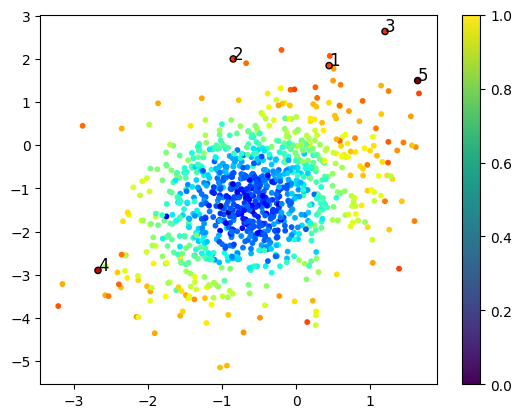

Acquistion Function : LCB 
______________________________

Step 1


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.90it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55793.7187]



Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.68it/s, init loss: 1219386.7387, avg. loss [951-1000]: 55800.0238]



Inferred GP kernel parameters
k_length         [1.4061 0.9697]
k_scale          6.236400000000001
noise            2.3471
Train Loss: 153.49269826402957
Test Loss: 41750.13571350207
Pearson Coeff: -0.06042766600153737

Step 3


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.21it/s, init loss: 1220754.4629, avg. loss [951-1000]: 55812.2648]



Inferred GP kernel parameters
k_length         [1.4018 0.9692]
k_scale          6.2302
noise            2.3539000000000003
Train Loss: 153.57200715493107
Test Loss: 45518.706952321896
Pearson Coeff: -0.07719724237115615

Step 4


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 425.43it/s, init loss: 1223580.4929, avg. loss [951-1000]: 55836.1565]



Inferred GP kernel parameters
k_length         [1.4208 0.9787]
k_scale          6.201300000000001
noise            2.3718
Train Loss: 144.77097606081918
Test Loss: 42331.89110921191
Pearson Coeff: -0.06740486787257778

Step 5


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.59it/s, init loss: 1229329.7420, avg. loss [951-1000]: 55966.8415]



Inferred GP kernel parameters
k_length         [1.4208 0.9574]
k_scale          6.1771
noise            2.3669000000000002
Train Loss: 141.6075575433065
Test Loss: 42550.4609715723
Pearson Coeff: -0.05811267068839224

Step 6


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 422.47it/s, init loss: 1234676.2206, avg. loss [951-1000]: 56030.6125]



Inferred GP kernel parameters
k_length         [1.4111 0.971 ]
k_scale          6.1713000000000005
noise            2.3664
Train Loss: 157.1793748750653
Test Loss: 43325.91347129517
Pearson Coeff: -0.06198756916310766

Step 7


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.15it/s, init loss: 1239720.7219, avg. loss [951-1000]: 56060.2322]



Inferred GP kernel parameters
k_length         [1.3957 0.9572]
k_scale          6.1526000000000005
noise            2.3785000000000003
Train Loss: 148.9348909391617
Test Loss: 44658.17177091274
Pearson Coeff: -0.05425844761363082

Step 8


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 289.21it/s, init loss: 1251305.6825, avg. loss [951-1000]: 56122.8470]



Inferred GP kernel parameters
k_length         [1.4155 0.957 ]
k_scale          6.1809
noise            2.3755
Train Loss: 140.31564623089923
Test Loss: 44847.90572969396
Pearson Coeff: -0.07480390490912577

Step 9


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.53it/s, init loss: 1260401.1145, avg. loss [951-1000]: 56184.1256]



Inferred GP kernel parameters
k_length         [1.4279 0.957 ]
k_scale          6.1379
noise            2.4075
Train Loss: 126.06759559393234
Test Loss: 41377.70881992522
Pearson Coeff: -0.08093748392772225

Step 10


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.97it/s, init loss: 1261969.0644, avg. loss [951-1000]: 56710.0475]



Inferred GP kernel parameters
k_length         [1.44   0.9735]
k_scale          6.119800000000001
noise            2.4104
Train Loss: 129.29581931284363
Test Loss: 38286.43552037929
Pearson Coeff: -0.06260375225622332

Step 11


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.75it/s, init loss: 1286281.3130, avg. loss [951-1000]: 57361.0974]



Inferred GP kernel parameters
k_length         [1.4018 0.9716]
k_scale          6.0961
noise            2.3592
Train Loss: 194.16910544943724
Test Loss: 36641.59156322548
Pearson Coeff: -0.045619419991948996

Step 12


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 364.54it/s, init loss: 1293325.8219, avg. loss [951-1000]: 56498.3150]



Inferred GP kernel parameters
k_length         [1.3926 0.9613]
k_scale          6.043200000000001
noise            2.3555
Train Loss: 139.34801210036787
Test Loss: 44304.03905371048
Pearson Coeff: -0.056645408325147494

Step 13


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 347.92it/s, init loss: 1295336.8520, avg. loss [951-1000]: 56507.2735]



Inferred GP kernel parameters
k_length         [1.4145 0.9606]
k_scale          6.0552
noise            2.3759
Train Loss: 134.57816194077634
Test Loss: 44399.61994057518
Pearson Coeff: -0.0476572223673912

Step 14


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.18it/s, init loss: 1297509.9440, avg. loss [951-1000]: 56494.7846]



Inferred GP kernel parameters
k_length         [1.3952 0.9615]
k_scale          6.0679
noise            2.3754
Train Loss: 127.90970339907166
Test Loss: 43403.51583755353
Pearson Coeff: -0.0486822718270599

Step 15


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.22it/s, init loss: 1299079.1582, avg. loss [951-1000]: 56311.6515]



Inferred GP kernel parameters
k_length         [1.4263 0.9711]
k_scale          6.071400000000001
noise            2.4045
Train Loss: 118.6437759590758
Test Loss: 37120.053002103545
Pearson Coeff: -0.0702932443126938

Step 16


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.05it/s, init loss: 1315826.8396, avg. loss [951-1000]: 56346.5657]



Inferred GP kernel parameters
k_length         [1.4095 0.9743]
k_scale          6.0574
noise            2.3645
Train Loss: 100.76516603374553
Test Loss: 38567.01941687471
Pearson Coeff: -0.06919595747838866

Step 17


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 247.53it/s, init loss: 1321211.2235, avg. loss [951-1000]: 56645.9970]



Inferred GP kernel parameters
k_length         [1.4005 0.9474]
k_scale          6.0225
noise            2.3809
Train Loss: 114.97804166769106
Test Loss: 42240.108007770774
Pearson Coeff: -0.08559768748727331

Step 18


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.45it/s, init loss: 1326293.4468, avg. loss [951-1000]: 56624.3492]



Inferred GP kernel parameters
k_length         [1.3957 0.9706]
k_scale          6.0099
noise            2.4143000000000003
Train Loss: 107.21355497000124
Test Loss: 44027.32340922687
Pearson Coeff: -0.06989384770489013

Step 19


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.72it/s, init loss: 1334831.3427, avg. loss [951-1000]: 56743.9441]



Inferred GP kernel parameters
k_length         [1.4005 0.9547]
k_scale          6.0364
noise            2.4162
Train Loss: 121.82166137369452
Test Loss: 43836.53535508235
Pearson Coeff: -0.08939054928269065

Step 20


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.76it/s, init loss: 1335079.8503, avg. loss [951-1000]: 56650.7610]



Inferred GP kernel parameters
k_length         [1.4232 0.9691]
k_scale          6.053100000000001
noise            2.4132000000000002
Train Loss: 113.29282850892429
Test Loss: 39188.89116600593
Pearson Coeff: -0.09201311821183644

Step 21


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 246.02it/s, init loss: 1339245.0285, avg. loss [951-1000]: 56651.1389]



Inferred GP kernel parameters
k_length         [1.4073 0.9674]
k_scale          6.0364
noise            2.4051
Train Loss: 95.40948587224513
Test Loss: 42390.60597863358
Pearson Coeff: -0.06234795080142713

Step 22


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.95it/s, init loss: 1340120.9270, avg. loss [951-1000]: 56626.0553]



Inferred GP kernel parameters
k_length         [1.4188 0.9699]
k_scale          6.029800000000001
noise            2.4256
Train Loss: 97.67466707946309
Test Loss: 41900.09933953694
Pearson Coeff: -0.09230153709164385

Step 23


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 261.97it/s, init loss: 1343662.5860, avg. loss [951-1000]: 56868.3492]



Inferred GP kernel parameters
k_length         [1.4039 0.9626]
k_scale          6.009600000000001
noise            2.3797
Train Loss: 97.70597112077073
Test Loss: 42523.5595613152
Pearson Coeff: -0.07803408528597999

Step 24


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.61it/s, init loss: 1345476.5368, avg. loss [951-1000]: 56690.5205]



Inferred GP kernel parameters
k_length         [1.4249 0.9689]
k_scale          6.0120000000000005
noise            2.3821000000000003
Train Loss: 95.6421029230411
Test Loss: 39088.96788837092
Pearson Coeff: -0.08970032863116237

Step 25


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.22it/s, init loss: 1348647.5247, avg. loss [951-1000]: 56955.1020]



Inferred GP kernel parameters
k_length         [1.4211 0.9599]
k_scale          5.973400000000001
noise            2.3943000000000003
Train Loss: 92.34168634648219
Test Loss: 42440.655193376246
Pearson Coeff: -0.06527112498044495

Step 26


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.80it/s, init loss: 1349017.3632, avg. loss [951-1000]: 56954.6126]



Inferred GP kernel parameters
k_length         [1.4313 0.945 ]
k_scale          5.9791
noise            2.407
Train Loss: 91.38711000772778
Test Loss: 45027.5299612828
Pearson Coeff: -0.06764358385339517

Step 27


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.62it/s, init loss: 1351048.4285, avg. loss [951-1000]: 56878.5926]



Inferred GP kernel parameters
k_length         [1.4216 0.9583]
k_scale          5.968100000000001
noise            2.4358
Train Loss: 91.54766185398539
Test Loss: 43249.63992613404
Pearson Coeff: -0.09370547124457754

Step 28


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.12it/s, init loss: 1352475.9561, avg. loss [951-1000]: 56978.1367]



Inferred GP kernel parameters
k_length         [1.4168 0.9533]
k_scale          5.9707
noise            2.4198
Train Loss: 96.85855413784982
Test Loss: 45930.74588731519
Pearson Coeff: -0.08131296156458033

Step 29


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.86it/s, init loss: 1357381.1225, avg. loss [951-1000]: 57102.0176]



Inferred GP kernel parameters
k_length         [1.4273 0.9615]
k_scale          5.978400000000001
noise            2.4330000000000003
Train Loss: 106.25523892173806
Test Loss: 41589.39960816698
Pearson Coeff: -0.06640257075969795

Step 30


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.80it/s, init loss: 1389132.2803, avg. loss [951-1000]: 57277.5101]



Inferred GP kernel parameters
k_length         [1.4198 0.9679]
k_scale          5.9295
noise            2.4008000000000003
Train Loss: 85.52983975285515
Test Loss: 43505.71525156427
Pearson Coeff: -0.08933623422878968

Step 31


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.42it/s, init loss: 1391600.7256, avg. loss [951-1000]: 57305.1120]



Inferred GP kernel parameters
k_length         [1.4203 0.9584]
k_scale          5.9118
noise            2.4209
Train Loss: 90.99889904900336
Test Loss: 43266.12110927952
Pearson Coeff: -0.07119194980399463

Step 32


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 229.42it/s, init loss: 1411095.8086, avg. loss [951-1000]: 57427.5876]



Inferred GP kernel parameters
k_length         [1.4206 0.957 ]
k_scale          5.8912
noise            2.4023000000000003
Train Loss: 86.98228455843726
Test Loss: 42945.974490372
Pearson Coeff: -0.07295700880953014

Step 33


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.25it/s, init loss: 1414268.1620, avg. loss [951-1000]: 57498.7064]



Inferred GP kernel parameters
k_length         [1.4292 0.9458]
k_scale          5.8647
noise            2.4055
Train Loss: 87.97898905040894
Test Loss: 45262.27208137786
Pearson Coeff: -0.061942310145205494

Step 34


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.59it/s, init loss: 1414271.3020, avg. loss [951-1000]: 57475.6632]



Inferred GP kernel parameters
k_length         [1.4321 0.9623]
k_scale          5.8707
noise            2.4148
Train Loss: 101.3066669837258
Test Loss: 41457.99476944357
Pearson Coeff: -0.051612156164075565

Step 35


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.43it/s, init loss: 1414573.3972, avg. loss [951-1000]: 57528.1707]



Inferred GP kernel parameters
k_length         [1.4311 0.9661]
k_scale          5.8582
noise            2.4265000000000003
Train Loss: 90.65247992853244
Test Loss: 43556.6037641894
Pearson Coeff: -0.04679291216153541

Step 36


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.49it/s, init loss: 1416208.3289, avg. loss [951-1000]: 57510.3000]



Inferred GP kernel parameters
k_length         [1.4207 0.9618]
k_scale          5.8704
noise            2.3932
Train Loss: 90.56467253664817
Test Loss: 40673.02178611218
Pearson Coeff: -0.05705489302447465

Step 37


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 221.57it/s, init loss: 1419048.0775, avg. loss [951-1000]: 57444.7457]



Inferred GP kernel parameters
k_length         [1.4309 0.9759]
k_scale          5.8609
noise            2.4301
Train Loss: 77.16283416348084
Test Loss: 38056.32587808481
Pearson Coeff: -0.07843756415317331

Step 38


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.16it/s, init loss: 1420357.0655, avg. loss [951-1000]: 57451.4980]



Inferred GP kernel parameters
k_length         [1.4295 0.971 ]
k_scale          5.855
noise            2.3969
Train Loss: 85.70821618099943
Test Loss: 38581.12056645682
Pearson Coeff: -0.059687123575512556

Step 39


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.01it/s, init loss: 1423551.4343, avg. loss [951-1000]: 57655.5167]



Inferred GP kernel parameters
k_length         [1.4303 0.9591]
k_scale          5.8319
noise            2.4087
Train Loss: 92.02505376788378
Test Loss: 43709.292667189664
Pearson Coeff: -0.07718535812005736

Step 40


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.57it/s, init loss: 1425210.0441, avg. loss [951-1000]: 57648.5850]



Inferred GP kernel parameters
k_length         [1.4269 0.971 ]
k_scale          5.8211
noise            2.4214
Train Loss: 94.0704352385894
Test Loss: 38743.950998952234
Pearson Coeff: -0.0717670843132819

Step 41


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.10it/s, init loss: 1428287.6758, avg. loss [951-1000]: 57517.2222]



Inferred GP kernel parameters
k_length         [1.4321 0.9637]
k_scale          5.829000000000001
noise            2.4297
Train Loss: 83.4477136194873
Test Loss: 39652.848715016386
Pearson Coeff: -0.07439016878598971

Step 42


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.86it/s, init loss: 1435679.1452, avg. loss [951-1000]: 57733.9601]



Inferred GP kernel parameters
k_length         [1.4309 0.9569]
k_scale          5.8257
noise            2.3612
Train Loss: 93.08870154639746
Test Loss: 42665.927165707624
Pearson Coeff: -0.05712324963488431

Step 43


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.26it/s, init loss: 1437250.2266, avg. loss [951-1000]: 57645.3428]



Inferred GP kernel parameters
k_length         [1.4383 0.9791]
k_scale          5.8186
noise            2.3692
Train Loss: 80.19059738735366
Test Loss: 36326.463198030724
Pearson Coeff: -0.07809510479685498

Step 44


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.45it/s, init loss: 1437636.6944, avg. loss [951-1000]: 57743.8681]



Inferred GP kernel parameters
k_length         [1.4407 0.9604]
k_scale          5.819500000000001
noise            2.3987000000000003
Train Loss: 90.2928379964586
Test Loss: 42244.53482807642
Pearson Coeff: -0.07903358833414247

Step 45


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.02it/s, init loss: 1443674.9257, avg. loss [951-1000]: 57882.0387]



Inferred GP kernel parameters
k_length         [1.4425 0.9753]
k_scale          5.8178
noise            2.4149000000000003
Train Loss: 76.14351668451658
Test Loss: 41801.84975079272
Pearson Coeff: -0.05453533004999058

Step 46


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.48it/s, init loss: 1444717.1460, avg. loss [951-1000]: 57876.0956]



Inferred GP kernel parameters
k_length         [1.4395 0.9644]
k_scale          5.82
noise            2.418
Train Loss: 87.66047640300931
Test Loss: 40923.196354834734
Pearson Coeff: -0.07581190209809666

Step 47


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.69it/s, init loss: 1445170.8168, avg. loss [951-1000]: 57864.7170]



Inferred GP kernel parameters
k_length         [1.4357 0.9769]
k_scale          5.8083
noise            2.4089
Train Loss: 83.77480348326817
Test Loss: 39720.09130679803
Pearson Coeff: -0.07022668659980659

Step 48


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.43it/s, init loss: 1447004.3304, avg. loss [951-1000]: 57858.6787]



Inferred GP kernel parameters
k_length         [1.4345 0.9624]
k_scale          5.8082
noise            2.3999
Train Loss: 86.99719406246876
Test Loss: 39650.15460464598
Pearson Coeff: -0.07155077859061898

Step 49


100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.59it/s, init loss: 1447015.7862, avg. loss [951-1000]: 58000.4586]



Inferred GP kernel parameters
k_length         [1.4361 0.9727]
k_scale          5.805400000000001
noise            2.3979
Train Loss: 81.86251740118524
Test Loss: 40398.86463413789
Pearson Coeff: -0.08463140069615799

Step 50


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.79it/s, init loss: 1447139.1891, avg. loss [951-1000]: 57775.2108]



Inferred GP kernel parameters
k_length         [1.4358 0.9882]
k_scale          5.8127
noise            2.4063000000000003
Train Loss: 79.32622287597408
Test Loss: 35938.411831639656
Pearson Coeff: -0.06114787608199256
Target Property : Enthalpy
Acquisition Function : LCB


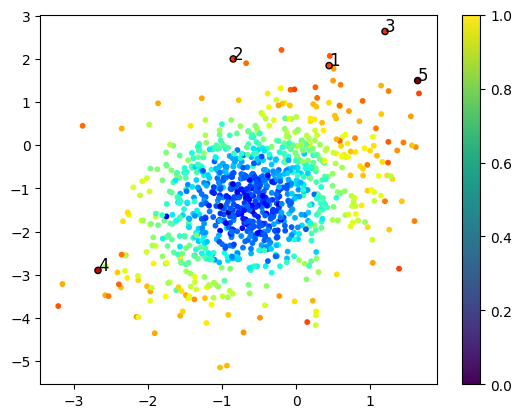

Acquistion Function : UCB 
______________________________

Step 1


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 420.88it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55793.7187]



Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 417.64it/s, init loss: 1219386.7387, avg. loss [951-1000]: 55800.0238]



Inferred GP kernel parameters
k_length         [1.4061 0.9697]
k_scale          6.236400000000001
noise            2.3471
Train Loss: 153.49269826402957
Test Loss: 41750.13571350207
Pearson Coeff: -0.06042766600153737

Step 3


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.36it/s, init loss: 1220754.4629, avg. loss [951-1000]: 55812.2648]



Inferred GP kernel parameters
k_length         [1.4018 0.9692]
k_scale          6.2302
noise            2.3539000000000003
Train Loss: 153.57200715493107
Test Loss: 45518.706952321896
Pearson Coeff: -0.07719724237115615

Step 4


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.20it/s, init loss: 1223580.4929, avg. loss [951-1000]: 55836.1565]



Inferred GP kernel parameters
k_length         [1.4208 0.9787]
k_scale          6.201300000000001
noise            2.3718
Train Loss: 144.77097606081918
Test Loss: 42331.89110921191
Pearson Coeff: -0.06740486787257778

Step 5


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.22it/s, init loss: 1229329.7420, avg. loss [951-1000]: 55966.8415]



Inferred GP kernel parameters
k_length         [1.4208 0.9574]
k_scale          6.1771
noise            2.3669000000000002
Train Loss: 141.6075575433065
Test Loss: 42550.4609715723
Pearson Coeff: -0.05811267068839224

Step 6


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.56it/s, init loss: 1234676.2206, avg. loss [951-1000]: 56030.6125]



Inferred GP kernel parameters
k_length         [1.4111 0.971 ]
k_scale          6.1713000000000005
noise            2.3664
Train Loss: 157.1793748750653
Test Loss: 43325.91347129517
Pearson Coeff: -0.06198756916310766

Step 7


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 403.66it/s, init loss: 1239720.7219, avg. loss [951-1000]: 56060.2322]



Inferred GP kernel parameters
k_length         [1.3957 0.9572]
k_scale          6.1526000000000005
noise            2.3785000000000003
Train Loss: 148.9348909391617
Test Loss: 44658.17177091274
Pearson Coeff: -0.05425844761363082

Step 8


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 410.86it/s, init loss: 1251305.6825, avg. loss [951-1000]: 56122.8470]



Inferred GP kernel parameters
k_length         [1.4155 0.957 ]
k_scale          6.1809
noise            2.3755
Train Loss: 140.31564623089923
Test Loss: 44847.90572969396
Pearson Coeff: -0.07480390490912577

Step 9


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.87it/s, init loss: 1260401.1145, avg. loss [951-1000]: 56184.1256]



Inferred GP kernel parameters
k_length         [1.4279 0.957 ]
k_scale          6.1379
noise            2.4075
Train Loss: 126.06759559393234
Test Loss: 41377.70881992522
Pearson Coeff: -0.08093748392772225

Step 10


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.05it/s, init loss: 1261969.0644, avg. loss [951-1000]: 56710.0475]



Inferred GP kernel parameters
k_length         [1.44   0.9735]
k_scale          6.119800000000001
noise            2.4104
Train Loss: 129.29581931284363
Test Loss: 38286.43552037929
Pearson Coeff: -0.06260375225622332

Step 11


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.40it/s, init loss: 1286281.3130, avg. loss [951-1000]: 57361.0974]



Inferred GP kernel parameters
k_length         [1.4018 0.9716]
k_scale          6.0961
noise            2.3592
Train Loss: 194.16910544943724
Test Loss: 36641.59156322548
Pearson Coeff: -0.045619419991948996

Step 12


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.88it/s, init loss: 1293325.8219, avg. loss [951-1000]: 56498.3150]



Inferred GP kernel parameters
k_length         [1.3926 0.9613]
k_scale          6.043200000000001
noise            2.3555
Train Loss: 139.34801210036787
Test Loss: 44304.03905371048
Pearson Coeff: -0.056645408325147494

Step 13


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 333.08it/s, init loss: 1295336.8520, avg. loss [951-1000]: 56507.2735]



Inferred GP kernel parameters
k_length         [1.4145 0.9606]
k_scale          6.0552
noise            2.3759
Train Loss: 134.57816194077634
Test Loss: 44399.61994057518
Pearson Coeff: -0.0476572223673912

Step 14


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 296.79it/s, init loss: 1297509.9440, avg. loss [951-1000]: 56494.7846]



Inferred GP kernel parameters
k_length         [1.3952 0.9615]
k_scale          6.0679
noise            2.3754
Train Loss: 127.90970339907166
Test Loss: 43403.51583755353
Pearson Coeff: -0.0486822718270599

Step 15


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.17it/s, init loss: 1299079.1582, avg. loss [951-1000]: 56311.6515]



Inferred GP kernel parameters
k_length         [1.4263 0.9711]
k_scale          6.071400000000001
noise            2.4045
Train Loss: 118.6437759590758
Test Loss: 37120.053002103545
Pearson Coeff: -0.0702932443126938

Step 16


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.30it/s, init loss: 1315826.8396, avg. loss [951-1000]: 56346.5657]



Inferred GP kernel parameters
k_length         [1.4095 0.9743]
k_scale          6.0574
noise            2.3645
Train Loss: 100.76516603374553
Test Loss: 38567.01941687471
Pearson Coeff: -0.06919595747838866

Step 17


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 256.99it/s, init loss: 1321211.2235, avg. loss [951-1000]: 56645.9970]



Inferred GP kernel parameters
k_length         [1.4005 0.9474]
k_scale          6.0225
noise            2.3809
Train Loss: 114.97804166769106
Test Loss: 42240.108007770774
Pearson Coeff: -0.08559768748727331

Step 18


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.63it/s, init loss: 1326293.4468, avg. loss [951-1000]: 56624.3492]



Inferred GP kernel parameters
k_length         [1.3957 0.9706]
k_scale          6.0099
noise            2.4143000000000003
Train Loss: 107.21355497000124
Test Loss: 44027.32340922687
Pearson Coeff: -0.06989384770489013

Step 19


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.81it/s, init loss: 1334831.3427, avg. loss [951-1000]: 56743.9441]



Inferred GP kernel parameters
k_length         [1.4005 0.9547]
k_scale          6.0364
noise            2.4162
Train Loss: 121.82166137369452
Test Loss: 43836.53535508235
Pearson Coeff: -0.08939054928269065

Step 20


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.82it/s, init loss: 1335079.8503, avg. loss [951-1000]: 56650.7610]



Inferred GP kernel parameters
k_length         [1.4232 0.9691]
k_scale          6.053100000000001
noise            2.4132000000000002
Train Loss: 113.29282850892429
Test Loss: 39188.89116600593
Pearson Coeff: -0.09201311821183644

Step 21


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 249.37it/s, init loss: 1339245.0285, avg. loss [951-1000]: 56651.1389]



Inferred GP kernel parameters
k_length         [1.4073 0.9674]
k_scale          6.0364
noise            2.4051
Train Loss: 95.40948587224513
Test Loss: 42390.60597863358
Pearson Coeff: -0.06234795080142713

Step 22


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.39it/s, init loss: 1340120.9270, avg. loss [951-1000]: 56626.0553]



Inferred GP kernel parameters
k_length         [1.4188 0.9699]
k_scale          6.029800000000001
noise            2.4256
Train Loss: 97.67466707946309
Test Loss: 41900.09933953694
Pearson Coeff: -0.09230153709164385

Step 23


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.41it/s, init loss: 1343662.5860, avg. loss [951-1000]: 56868.3492]



Inferred GP kernel parameters
k_length         [1.4039 0.9626]
k_scale          6.009600000000001
noise            2.3797
Train Loss: 97.70597112077073
Test Loss: 42523.5595613152
Pearson Coeff: -0.07803408528597999

Step 24


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.78it/s, init loss: 1345476.5368, avg. loss [951-1000]: 56690.5205]



Inferred GP kernel parameters
k_length         [1.4249 0.9689]
k_scale          6.0120000000000005
noise            2.3821000000000003
Train Loss: 95.6421029230411
Test Loss: 39088.96788837092
Pearson Coeff: -0.08970032863116237

Step 25


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.06it/s, init loss: 1348647.5247, avg. loss [951-1000]: 56955.1020]



Inferred GP kernel parameters
k_length         [1.4211 0.9599]
k_scale          5.973400000000001
noise            2.3943000000000003
Train Loss: 92.34168634648219
Test Loss: 42440.655193376246
Pearson Coeff: -0.06527112498044495

Step 26


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.80it/s, init loss: 1349017.3632, avg. loss [951-1000]: 56954.6126]



Inferred GP kernel parameters
k_length         [1.4313 0.945 ]
k_scale          5.9791
noise            2.407
Train Loss: 91.38711000772778
Test Loss: 45027.5299612828
Pearson Coeff: -0.06764358385339517

Step 27


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 247.41it/s, init loss: 1351048.4285, avg. loss [951-1000]: 56878.5926]



Inferred GP kernel parameters
k_length         [1.4216 0.9583]
k_scale          5.968100000000001
noise            2.4358
Train Loss: 91.54766185398539
Test Loss: 43249.63992613404
Pearson Coeff: -0.09370547124457754

Step 28


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 245.49it/s, init loss: 1352475.9561, avg. loss [951-1000]: 56978.1367]



Inferred GP kernel parameters
k_length         [1.4168 0.9533]
k_scale          5.9707
noise            2.4198
Train Loss: 96.85855413784982
Test Loss: 45930.74588731519
Pearson Coeff: -0.08131296156458033

Step 29


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.31it/s, init loss: 1357381.1225, avg. loss [951-1000]: 57102.0176]



Inferred GP kernel parameters
k_length         [1.4273 0.9615]
k_scale          5.978400000000001
noise            2.4330000000000003
Train Loss: 106.25523892173806
Test Loss: 41589.39960816698
Pearson Coeff: -0.06640257075969795

Step 30


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.85it/s, init loss: 1389132.2803, avg. loss [951-1000]: 57277.5101]



Inferred GP kernel parameters
k_length         [1.4198 0.9679]
k_scale          5.9295
noise            2.4008000000000003
Train Loss: 85.52983975285515
Test Loss: 43505.71525156427
Pearson Coeff: -0.08933623422878968

Step 31


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 244.15it/s, init loss: 1391600.7256, avg. loss [951-1000]: 57305.1120]



Inferred GP kernel parameters
k_length         [1.4203 0.9584]
k_scale          5.9118
noise            2.4209
Train Loss: 90.99889904900336
Test Loss: 43266.12110927952
Pearson Coeff: -0.07119194980399463

Step 32


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.28it/s, init loss: 1411095.8086, avg. loss [951-1000]: 57427.5876]



Inferred GP kernel parameters
k_length         [1.4206 0.957 ]
k_scale          5.8912
noise            2.4023000000000003
Train Loss: 86.98228455843726
Test Loss: 42945.974490372
Pearson Coeff: -0.07295700880953014

Step 33


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.01it/s, init loss: 1414268.1620, avg. loss [951-1000]: 57498.7064]



Inferred GP kernel parameters
k_length         [1.4292 0.9458]
k_scale          5.8647
noise            2.4055
Train Loss: 87.97898905040894
Test Loss: 45262.27208137786
Pearson Coeff: -0.061942310145205494

Step 34


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.58it/s, init loss: 1414271.3020, avg. loss [951-1000]: 57475.6632]



Inferred GP kernel parameters
k_length         [1.4321 0.9623]
k_scale          5.8707
noise            2.4148
Train Loss: 101.3066669837258
Test Loss: 41457.99476944357
Pearson Coeff: -0.051612156164075565

Step 35


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 230.77it/s, init loss: 1414573.3972, avg. loss [951-1000]: 57528.1707]



Inferred GP kernel parameters
k_length         [1.4311 0.9661]
k_scale          5.8582
noise            2.4265000000000003
Train Loss: 90.65247992853244
Test Loss: 43556.6037641894
Pearson Coeff: -0.04679291216153541

Step 36


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 218.30it/s, init loss: 1416208.3289, avg. loss [951-1000]: 57510.3000]



Inferred GP kernel parameters
k_length         [1.4207 0.9618]
k_scale          5.8704
noise            2.3932
Train Loss: 90.56467253664817
Test Loss: 40673.02178611218
Pearson Coeff: -0.05705489302447465

Step 37


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.36it/s, init loss: 1419048.0775, avg. loss [951-1000]: 57444.7457]



Inferred GP kernel parameters
k_length         [1.4309 0.9759]
k_scale          5.8609
noise            2.4301
Train Loss: 77.16283416348084
Test Loss: 38056.32587808481
Pearson Coeff: -0.07843756415317331

Step 38


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.33it/s, init loss: 1420357.0655, avg. loss [951-1000]: 57451.4980]



Inferred GP kernel parameters
k_length         [1.4295 0.971 ]
k_scale          5.855
noise            2.3969
Train Loss: 85.70821618099943
Test Loss: 38581.12056645682
Pearson Coeff: -0.059687123575512556

Step 39


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.19it/s, init loss: 1423551.4343, avg. loss [951-1000]: 57655.5167]



Inferred GP kernel parameters
k_length         [1.4303 0.9591]
k_scale          5.8319
noise            2.4087
Train Loss: 92.02505376788378
Test Loss: 43709.292667189664
Pearson Coeff: -0.07718535812005736

Step 40


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.65it/s, init loss: 1425210.0441, avg. loss [951-1000]: 57648.5850]



Inferred GP kernel parameters
k_length         [1.4269 0.971 ]
k_scale          5.8211
noise            2.4214
Train Loss: 94.0704352385894
Test Loss: 38743.950998952234
Pearson Coeff: -0.0717670843132819

Step 41


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.88it/s, init loss: 1428287.6758, avg. loss [951-1000]: 57517.2222]



Inferred GP kernel parameters
k_length         [1.4321 0.9637]
k_scale          5.829000000000001
noise            2.4297
Train Loss: 83.4477136194873
Test Loss: 39652.848715016386
Pearson Coeff: -0.07439016878598971

Step 42


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.27it/s, init loss: 1435679.1452, avg. loss [951-1000]: 57733.9601]



Inferred GP kernel parameters
k_length         [1.4309 0.9569]
k_scale          5.8257
noise            2.3612
Train Loss: 93.08870154639746
Test Loss: 42665.927165707624
Pearson Coeff: -0.05712324963488431

Step 43


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.67it/s, init loss: 1437250.2266, avg. loss [951-1000]: 57645.3428]



Inferred GP kernel parameters
k_length         [1.4383 0.9791]
k_scale          5.8186
noise            2.3692
Train Loss: 80.19059738735366
Test Loss: 36326.463198030724
Pearson Coeff: -0.07809510479685498

Step 44


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.15it/s, init loss: 1437636.6944, avg. loss [951-1000]: 57743.8681]



Inferred GP kernel parameters
k_length         [1.4407 0.9604]
k_scale          5.819500000000001
noise            2.3987000000000003
Train Loss: 90.2928379964586
Test Loss: 42244.53482807642
Pearson Coeff: -0.07903358833414247

Step 45


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.66it/s, init loss: 1443674.9257, avg. loss [951-1000]: 57882.0387]



Inferred GP kernel parameters
k_length         [1.4425 0.9753]
k_scale          5.8178
noise            2.4149000000000003
Train Loss: 76.14351668451658
Test Loss: 41801.84975079272
Pearson Coeff: -0.05453533004999058

Step 46


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 212.73it/s, init loss: 1444717.1460, avg. loss [951-1000]: 57876.0956]



Inferred GP kernel parameters
k_length         [1.4395 0.9644]
k_scale          5.82
noise            2.418
Train Loss: 87.66047640300931
Test Loss: 40923.196354834734
Pearson Coeff: -0.07581190209809666

Step 47


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.48it/s, init loss: 1445170.8168, avg. loss [951-1000]: 57864.7170]



Inferred GP kernel parameters
k_length         [1.4357 0.9769]
k_scale          5.8083
noise            2.4089
Train Loss: 83.77480348326817
Test Loss: 39720.09130679803
Pearson Coeff: -0.07022668659980659

Step 48


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.39it/s, init loss: 1447004.3304, avg. loss [951-1000]: 57858.6787]



Inferred GP kernel parameters
k_length         [1.4345 0.9624]
k_scale          5.8082
noise            2.3999
Train Loss: 86.99719406246876
Test Loss: 39650.15460464598
Pearson Coeff: -0.07155077859061898

Step 49


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.69it/s, init loss: 1447015.7862, avg. loss [951-1000]: 58000.4586]



Inferred GP kernel parameters
k_length         [1.4361 0.9727]
k_scale          5.805400000000001
noise            2.3979
Train Loss: 81.86251740118524
Test Loss: 40398.86463413789
Pearson Coeff: -0.08463140069615799

Step 50


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 201.78it/s, init loss: 1447139.1891, avg. loss [951-1000]: 57775.2108]



Inferred GP kernel parameters
k_length         [1.4358 0.9882]
k_scale          5.8127
noise            2.4063000000000003
Train Loss: 79.32622287597408
Test Loss: 35938.411831639656
Pearson Coeff: -0.06114787608199256
Target Property : Enthalpy
Acquisition Function : UCB


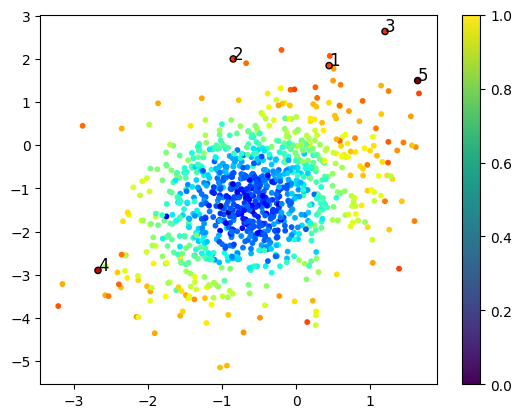

Acquistion Function : Entropy 
______________________________

Step 1


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.15it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55793.7187]



Inferred GP kernel parameters
k_length         [1.4005 0.9728]
k_scale          6.2304
noise            2.3708
Train Loss: 169.10342383871767
Test Loss: 41222.170855108205
Pearson Coeff: -0.028023893630656563

Step 2


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.21it/s, init loss: 1223933.8427, avg. loss [951-1000]: 55862.4242]



Inferred GP kernel parameters
k_length         [1.4215 0.9637]
k_scale          6.2183
noise            2.37
Train Loss: 164.05522684072332
Test Loss: 41728.79468048655
Pearson Coeff: -0.07869751154459373

Step 3


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.94it/s, init loss: 1230398.1623, avg. loss [951-1000]: 55965.4816]



Inferred GP kernel parameters
k_length         [1.4101 0.9689]
k_scale          6.1725
noise            2.379
Train Loss: 165.655431435347
Test Loss: 43687.37529172483
Pearson Coeff: -0.08655711675623791

Step 4


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 411.59it/s, init loss: 1239228.6549, avg. loss [951-1000]: 55936.4253]



Inferred GP kernel parameters
k_length         [1.4168 0.9754]
k_scale          6.15
noise            2.4179
Train Loss: 152.08801290903222
Test Loss: 42726.18324367811
Pearson Coeff: -0.08067581313629765

Step 5


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.00it/s, init loss: 1244283.7049, avg. loss [951-1000]: 56052.6977]



Inferred GP kernel parameters
k_length         [1.4075 0.9869]
k_scale          6.1188
noise            2.42
Train Loss: 142.5016552567305
Test Loss: 42997.735770989784
Pearson Coeff: -0.06860938039188763

Step 6


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 409.96it/s, init loss: 1246701.8965, avg. loss [951-1000]: 55965.6368]



Inferred GP kernel parameters
k_length         [1.4295 0.9978]
k_scale          6.1093
noise            2.4365
Train Loss: 135.6800111677523
Test Loss: 39402.00110705189
Pearson Coeff: -0.08135091636342842

Step 7


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.14it/s, init loss: 1252893.2219, avg. loss [951-1000]: 56242.6978]



Inferred GP kernel parameters
k_length         [1.3958 0.9724]
k_scale          6.0808
noise            2.3746
Train Loss: 143.12747211481096
Test Loss: 40812.122587676095
Pearson Coeff: -0.06618088626437588

Step 8


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 399.91it/s, init loss: 1255742.7181, avg. loss [951-1000]: 56335.5585]



Inferred GP kernel parameters
k_length         [1.3917 0.9767]
k_scale          6.056900000000001
noise            2.3929
Train Loss: 164.53377406095942
Test Loss: 43185.80542092732
Pearson Coeff: -0.07866094715537149

Step 9


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.66it/s, init loss: 1260290.9680, avg. loss [951-1000]: 56334.3548]



Inferred GP kernel parameters
k_length         [1.3964 0.9665]
k_scale          6.0511
noise            2.3967
Train Loss: 140.80915832882695
Test Loss: 46203.99605293888
Pearson Coeff: -0.07102622441098301

Step 10


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.98it/s, init loss: 1260513.7428, avg. loss [951-1000]: 56293.1160]



Inferred GP kernel parameters
k_length         [1.388 0.984]
k_scale          6.0492
noise            2.4028
Train Loss: 135.61593993178911
Test Loss: 39385.39262702028
Pearson Coeff: -0.08600105170788996

Step 11


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.27it/s, init loss: 1272677.6859, avg. loss [951-1000]: 56343.4269]



Inferred GP kernel parameters
k_length         [1.3983 0.9767]
k_scale          6.014
noise            2.4422
Train Loss: 135.2252343289
Test Loss: 38542.479983980586
Pearson Coeff: -0.06056289709228892

Step 12


100%|████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.54it/s, init loss: 1274131.4354, avg. loss [951-1000]: 56382.9782]



Inferred GP kernel parameters
k_length         [1.3966 0.9787]
k_scale          5.998600000000001
noise            2.3983000000000003
Train Loss: 126.93958236824662
Test Loss: 37288.797042459824
Pearson Coeff: -0.04491259837650713

Step 13


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 308.90it/s, init loss: 1276710.1026, avg. loss [951-1000]: 56533.4742]



Inferred GP kernel parameters
k_length         [1.3966 0.9409]
k_scale          5.9946
noise            2.3871
Train Loss: 175.98693706528658
Test Loss: 46687.67877128781
Pearson Coeff: -0.06687711609236234

Step 14


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 316.32it/s, init loss: 1279429.5957, avg. loss [951-1000]: 57502.0065]



Inferred GP kernel parameters
k_length         [1.4263 0.9949]
k_scale          5.9985
noise            2.4561
Train Loss: 364.0979009498955
Test Loss: 37478.00599465004
Pearson Coeff: -0.0988871437472379

Step 15


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 222.67it/s, init loss: 1283498.3596, avg. loss [951-1000]: 56471.6189]



Inferred GP kernel parameters
k_length         [1.4249 0.962 ]
k_scale          5.9415000000000004
noise            2.4681
Train Loss: 123.54191129189496
Test Loss: 40395.40410625158
Pearson Coeff: -0.09318571687511584

Step 16


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.91it/s, init loss: 1287861.0833, avg. loss [951-1000]: 56674.9805]



Inferred GP kernel parameters
k_length         [1.4078 0.9746]
k_scale          5.9202
noise            2.4366000000000003
Train Loss: 140.28784083282872
Test Loss: 40871.333649214845
Pearson Coeff: -0.09731656993793976

Step 17


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 228.50it/s, init loss: 1291330.7114, avg. loss [951-1000]: 56741.5167]



Inferred GP kernel parameters
k_length         [1.4011 0.9796]
k_scale          5.9314
noise            2.4195
Train Loss: 127.34020443628411
Test Loss: 40272.771781139185
Pearson Coeff: -0.10244559793566853

Step 18


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 251.98it/s, init loss: 1291810.5497, avg. loss [951-1000]: 56814.3047]



Inferred GP kernel parameters
k_length         [1.41   0.9562]
k_scale          5.915100000000001
noise            2.4152
Train Loss: 134.38321485394275
Test Loss: 41618.636822027576
Pearson Coeff: -0.08845108284913396

Step 19


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.51it/s, init loss: 1292440.5907, avg. loss [951-1000]: 56782.1357]



Inferred GP kernel parameters
k_length         [1.4146 0.9518]
k_scale          5.9194
noise            2.434
Train Loss: 150.96826229300473
Test Loss: 45372.278323321894
Pearson Coeff: -0.07029637602334271

Step 20


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 258.53it/s, init loss: 1293172.0559, avg. loss [951-1000]: 56839.2293]



Inferred GP kernel parameters
k_length         [1.4168 0.9553]
k_scale          5.9021
noise            2.4347000000000003
Train Loss: 127.1202961083377
Test Loss: 43722.67166657914
Pearson Coeff: -0.06031891347001215

Step 21


100%|████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.58it/s, init loss: 1300719.8184, avg. loss [951-1000]: 56882.3002]



Inferred GP kernel parameters
k_length         [1.4236 0.9922]
k_scale          5.850700000000001
noise            2.4671000000000003
Train Loss: 106.4299009232451
Test Loss: 36030.40528569162
Pearson Coeff: -0.08092045388859082

Step 22


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.54it/s, init loss: 1311660.9797, avg. loss [951-1000]: 56986.2491]



Inferred GP kernel parameters
k_length         [1.4138 0.9519]
k_scale          5.859100000000001
noise            2.4729
Train Loss: 147.61598385992414
Test Loss: 42052.44195803947
Pearson Coeff: -0.062373336550049244

Step 23


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.59it/s, init loss: 1325261.5730, avg. loss [951-1000]: 57072.5948]



Inferred GP kernel parameters
k_length         [1.4124 0.9607]
k_scale          5.816800000000001
noise            2.4728000000000003
Train Loss: 123.88822268243032
Test Loss: 39114.77605588347
Pearson Coeff: -0.08058534097079201

Step 24


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 240.43it/s, init loss: 1327579.5017, avg. loss [951-1000]: 57128.1556]



Inferred GP kernel parameters
k_length         [1.405  0.9649]
k_scale          5.8106
noise            2.4526000000000003
Train Loss: 108.59246436425711
Test Loss: 37373.7000894539
Pearson Coeff: -0.05250902989060005

Step 25


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.82it/s, init loss: 1336622.4755, avg. loss [951-1000]: 57175.6083]



Inferred GP kernel parameters
k_length         [1.3993 0.9649]
k_scale          5.7986
noise            2.4559
Train Loss: 114.72090518821055
Test Loss: 36945.27017689479
Pearson Coeff: -0.0702419034697433

Step 26


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 241.32it/s, init loss: 1337604.7287, avg. loss [951-1000]: 57229.0283]



Inferred GP kernel parameters
k_length         [1.4202 0.9364]
k_scale          5.7866
noise            2.4792
Train Loss: 103.50794962886741
Test Loss: 42721.241429969734
Pearson Coeff: -0.06792686518793113

Step 27


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.69it/s, init loss: 1358655.7041, avg. loss [951-1000]: 57272.8917]



Inferred GP kernel parameters
k_length         [1.4027 0.9566]
k_scale          5.7837000000000005
noise            2.4566000000000003
Train Loss: 103.55248978872999
Test Loss: 37346.444603659926
Pearson Coeff: -0.08318960012691515

Step 28


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 248.06it/s, init loss: 1362221.3889, avg. loss [951-1000]: 57260.0353]



Inferred GP kernel parameters
k_length         [1.4074 0.9466]
k_scale          5.7766
noise            2.4326000000000003
Train Loss: 118.11400971352784
Test Loss: 37295.75084692272
Pearson Coeff: -0.06103193339189724

Step 29


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.60it/s, init loss: 1367175.9505, avg. loss [951-1000]: 57388.9930]



Inferred GP kernel parameters
k_length         [1.4104 0.9326]
k_scale          5.7641
noise            2.427
Train Loss: 100.4919299746931
Test Loss: 42495.503397486944
Pearson Coeff: -0.053445520905241635

Step 30


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 221.57it/s, init loss: 1377443.1552, avg. loss [951-1000]: 57598.0493]



Inferred GP kernel parameters
k_length         [1.4142 0.9417]
k_scale          5.7694
noise            2.4812000000000003
Train Loss: 117.55610998249169
Test Loss: 36847.39983952008
Pearson Coeff: -0.06075133140923239

Step 31


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.73it/s, init loss: 1396348.3940, avg. loss [951-1000]: 57609.7755]



Inferred GP kernel parameters
k_length         [1.4184 0.9649]
k_scale          5.7563
noise            2.4655
Train Loss: 94.71889835922582
Test Loss: 34345.679424947986
Pearson Coeff: -0.06539350105300659

Step 32


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.76it/s, init loss: 1406128.5238, avg. loss [951-1000]: 57817.9304]



Inferred GP kernel parameters
k_length         [1.4298 0.9328]
k_scale          5.755
noise            2.4883
Train Loss: 103.0314073904841
Test Loss: 38304.957065693285
Pearson Coeff: -0.07168718715365179

Step 33


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.36it/s, init loss: 1406721.7108, avg. loss [951-1000]: 57770.5848]



Inferred GP kernel parameters
k_length         [1.4286 0.9387]
k_scale          5.7597000000000005
noise            2.4961
Train Loss: 119.27520464057335
Test Loss: 36140.502562707676
Pearson Coeff: -0.0728656464472805

Step 34


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 219.60it/s, init loss: 1465190.4397, avg. loss [951-1000]: 58362.0635]



Inferred GP kernel parameters
k_length         [1.4248 0.9664]
k_scale          5.702500000000001
noise            2.5217
Train Loss: 99.34707354842811
Test Loss: 33786.51525749584
Pearson Coeff: -0.05381423704445269

Step 35


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 217.42it/s, init loss: 1468227.7530, avg. loss [951-1000]: 58403.0535]



Inferred GP kernel parameters
k_length         [1.4263 0.9607]
k_scale          5.705900000000001
noise            2.5052000000000003
Train Loss: 109.40770394689012
Test Loss: 33459.87295285697
Pearson Coeff: -0.05983710825936422

Step 36


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.67it/s, init loss: 1471881.1574, avg. loss [951-1000]: 58315.9449]



Inferred GP kernel parameters
k_length         [1.4374 0.953 ]
k_scale          5.701700000000001
noise            2.5326
Train Loss: 101.20173470794208
Test Loss: 36164.76384447284
Pearson Coeff: -0.06081793078924952

Step 37


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.04it/s, init loss: 1472659.1020, avg. loss [951-1000]: 58422.4049]



Inferred GP kernel parameters
k_length         [1.429  0.9381]
k_scale          5.6867
noise            2.5307
Train Loss: 106.40839211100544
Test Loss: 38222.17264649456
Pearson Coeff: -0.05899128723452782

Step 38


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.46it/s, init loss: 1479277.9821, avg. loss [951-1000]: 58383.3798]



Inferred GP kernel parameters
k_length         [1.4181 0.9589]
k_scale          5.7049
noise            2.4802
Train Loss: 89.89452079122172
Test Loss: 32833.690457592085
Pearson Coeff: -0.08061755868476433

Step 39


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.89it/s, init loss: 1509378.9428, avg. loss [951-1000]: 58538.4910]



Inferred GP kernel parameters
k_length         [1.4269 0.9566]
k_scale          5.6628
noise            2.4793000000000003
Train Loss: 114.15038411563752
Test Loss: 33422.87125085855
Pearson Coeff: -0.058820306707416545

Step 40


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 215.39it/s, init loss: 1509904.0620, avg. loss [951-1000]: 58508.0042]



Inferred GP kernel parameters
k_length         [1.4372 0.9655]
k_scale          5.653300000000001
noise            2.5145
Train Loss: 99.4380295111909
Test Loss: 32244.339894560704
Pearson Coeff: -0.07486837727476386

Step 41


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.14it/s, init loss: 1513088.9130, avg. loss [951-1000]: 58639.8021]



Inferred GP kernel parameters
k_length         [1.4311 0.9522]
k_scale          5.645300000000001
noise            2.4867
Train Loss: 99.56238346576393
Test Loss: 32375.671909544297
Pearson Coeff: -0.05517547477839492

Step 42


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.57it/s, init loss: 1514056.0394, avg. loss [951-1000]: 58656.0329]



Inferred GP kernel parameters
k_length         [1.4182 0.949 ]
k_scale          5.6399
noise            2.4928
Train Loss: 86.34090162154864
Test Loss: 32292.347667102644
Pearson Coeff: -0.026026732722388063

Step 43


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.98it/s, init loss: 1515848.1773, avg. loss [951-1000]: 58632.0740]



Inferred GP kernel parameters
k_length         [1.426  0.9667]
k_scale          5.6303
noise            2.5307
Train Loss: 98.80832207850708
Test Loss: 30572.477216021754
Pearson Coeff: -0.0598230065339738

Step 44


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.48it/s, init loss: 1518481.4010, avg. loss [951-1000]: 58678.1471]



Inferred GP kernel parameters
k_length         [1.4346 0.9512]
k_scale          5.6321
noise            2.4928
Train Loss: 101.9333721295416
Test Loss: 32125.251941350314
Pearson Coeff: -0.04911540306822084

Step 45


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.95it/s, init loss: 1524230.7699, avg. loss [951-1000]: 58880.4458]



Inferred GP kernel parameters
k_length         [1.425  0.9558]
k_scale          5.5764000000000005
noise            2.5306
Train Loss: 95.14743211127757
Test Loss: 33431.31428282706
Pearson Coeff: -0.04231507125985303

Step 46


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.61it/s, init loss: 1542369.5054, avg. loss [951-1000]: 58783.4371]



Inferred GP kernel parameters
k_length         [1.4185 0.9564]
k_scale          5.5909
noise            2.4904
Train Loss: 92.60036404512026
Test Loss: 29974.22383634029
Pearson Coeff: -0.039018523466519746

Step 47


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.48it/s, init loss: 1563181.3442, avg. loss [951-1000]: 58989.1815]



Inferred GP kernel parameters
k_length         [1.4408 0.9461]
k_scale          5.541
noise            2.5069
Train Loss: 90.5685895127411
Test Loss: 33762.046968543254
Pearson Coeff: -0.027564229880228275

Step 48


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 193.93it/s, init loss: 1572049.3284, avg. loss [951-1000]: 59012.0380]



Inferred GP kernel parameters
k_length         [1.4328 0.9692]
k_scale          5.5273
noise            2.5364
Train Loss: 90.6023436880827
Test Loss: 30468.261086252918
Pearson Coeff: -0.05561109776805589

Step 49


100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.99it/s, init loss: 1578199.4196, avg. loss [951-1000]: 59055.3935]



Inferred GP kernel parameters
k_length         [1.4333 0.9607]
k_scale          5.5172
noise            2.5148
Train Loss: 84.52178178158266
Test Loss: 29418.42253758573
Pearson Coeff: -0.06214316804946843

Step 50


100%|████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 195.77it/s, init loss: 1587603.0146, avg. loss [951-1000]: 59163.4439]



Inferred GP kernel parameters
k_length         [1.4225 0.9602]
k_scale          5.4966
noise            2.527
Train Loss: 110.82995069917071
Test Loss: 31659.66275684299
Pearson Coeff: -0.07441391943585661
Target Property : Enthalpy
Acquisition Function : Entropy


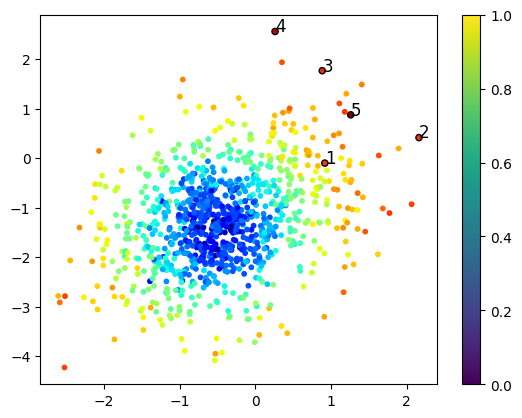

In [14]:
## Active Learning wiht Multiple Acquisition Functions

train_loss_dict = {} 
test_loss_dict = {}

objective_mean = {}
molecules = {} 


target_property = "enthalpy"
exploration_steps = 50
acquisition_functions = {'PI':probability_of_improvement, 'EI':expected_improvement, 'LCB':lower_confidence_bound, 'UCB':upper_confidence_bound , 'Entropy':entropy}

for acq in acquisition_functions:   
    np.random.seed(0)
    idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
    X1_train = X1[idx1]
    X1_unmeasured = np.delete(X1, idx1, axis=0)
    indices_total_1 = np.arange(len(X))
    indices_train_1 = indices_total_1[idx1]
    
    y1_train = targets1[idx1]
    y1_unmeasured = np.delete(targets1, idx1, axis=0)
    
    indices_unmeasured_1 = np.delete(indices_total_1, idx1)
    objective_func = []
    covariances = []
    train_loss = []
    test_loss = []
    # pearson_coeff = []
    exp_mean1, exp_std1 = [], []
    dkl_mean1, dkl_std1 = [], []
    embed_traj1 = []
    traj_mean1, traj_std1 = [], []
    objective_func = []

    print(f"Acquistion Function : {acq} \n{'_'*30}")
    for e in range(exploration_steps):
        print("\nStep {}".format(e+1))
        # Obtain/update DKL posterior
        rng_key11, rng_key_predict11 = gpax.utils.get_keys()
        dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
        
        if e == 0:
            nn,kernel = dkl_BO_1.get_samples()
        
        dkl_BO_1.fit(rng_key11, X1_train, y1_train)
        
        # Compute acqusition function
        y_mean, y_var = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_unmeasured, batch_size=250)
        y_std = jnp.sqrt(y_var)
    
        y_mean_t, y_var_t = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_train, batch_size=50)
    
        loss_fcn = torch.nn.MSELoss()
        y_tl, y1_tl = np.asarray(y_mean_t), np.asarray(y1_train)
        y_tsl, y1_tsl = np.asarray(y_mean), np.asarray(y1_unmeasured)
    
        train_loss.append(np.mean(np.square(y_tl - y1_tl)))
        test_loss.append(np.mean(np.square(y_tsl - y1_tsl)))#loss_fcn(measured_spectrum,predicted_spectrum)
        correlation_coefficient, _ = pearsonr(y1_tsl, y_tsl)
        # pearson_coeff.append(correlation_coefficient)
        print(f"Train Loss: {train_loss[-1]}")
        print(f"Test Loss: {test_loss[-1]}")
        print(f"Pearson Coeff: {correlation_coefficient}")
        #obj = y_mean + 10 * y_std
        
        obj = acquisition_functions[acq](y_mean,y_std)
        objective_func.append(obj)
        #np.save(f"VAEDKL_logs/object_{e+1}.npy",np.array(obj))
        # Get the next point to evaluate
        id_next = obj.argmax()
        
        # let's get the mean and std of the next point predicted by dkl_BO
        exp_mean1.append(y_mean[id_next])
        exp_std1.append(y_std[id_next])
    
        x_next = X1_unmeasured[id_next]
        ind_next = indices_unmeasured_1[id_next]
    
        # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
        dkl_mean1.append(pred_mean1[ind_next])
        dkl_std1.append(pred_std1[ind_next])
    
        # Perform evaluation
        y_measured = targets1[ind_next]
    
        # Update training arrays
        X1_train = np.append(X1_train, x_next[None], axis=0)
        y1_train = np.append(y1_train, y_measured)
        X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
        y1_unmeasured = np.delete(y1_unmeasured, id_next, axis=0)
        
        indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)
        
        embed_traj = dkl_BO_1.embed(X1_train)
        traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict11, X1_train, batch_size=batch_size_learn)        
        embed_traj1.append(embed_traj)
        traj_mean1.append(traj_m)
        traj_std1.append(traj_s)
    objective_mean[acq] = objective_func
    train_loss_dict[acq] = train_loss
    test_loss_dict[acq] = test_loss
    # pearson_dict[acq] = pearson_coeff
    


    ##############################################################################################################
    ##############################################################################################################
    ############ 5 Top molecules with highest errors ---> From each Acquisition Functions Comparison #############
    ##############################################################################################################
    ##############################################################################################################

        
    # Find indices of the 5 maximal points in pred_var5
    print("Target Property : Enthalpy")
    print(f"Acquisition Function : {acq}")
    
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    batch_size_reconstruct = 250
    pred_mean1, pred_var1 = dkl_BO_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
    embeded_1 = dkl_BO_1.embed(X1) 
    max_indices = np.argsort(targets1 - pred_mean1)[-5:]
    # Plot the original scatter plot
    plt.scatter(embeded_1[:, 1], embeded_1[:, 0], s=10,
                c=targets1 - pred_mean1, cmap='jet')
    
    # Plot circles and offset numbers around the 5 maximal points
    for i, idx in enumerate(max_indices):
        plt.scatter(embeded_1[idx, 1], embeded_1[idx, 0],
                    s=20, facecolors='none', edgecolors='black')
        # Offset the text slightly from the circle
        plt.text(embeded_1[idx, 1], embeded_1[idx, 0],
                 str(i+1), color='black', fontsize=12)
    
    plt.colorbar()
    plt.show()
    
    # Retrieve rows from df corresponding to max_indices
    maximal_rows = df.iloc[max_indices]
    
    # Extract SMILES strings in the order of max_indices
    smiles_list = maximal_rows['smiles'].tolist()
    
    # Convert SMILES to RDKit molecule objects in the same order
    molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    # Annotate molecules with numbers corresponding to their order
    for i, mol in enumerate(molecules_2):
        if mol is not None:
            mol.SetProp("_Name", str(i+1))

    molecules[acq] = smiles_list
    
    # Create a grid image of the molecules
    img = Draw.MolsToGridImage(molecules_2, molsPerRow=5, subImgSize=(200, 200), useSVG=True)
    


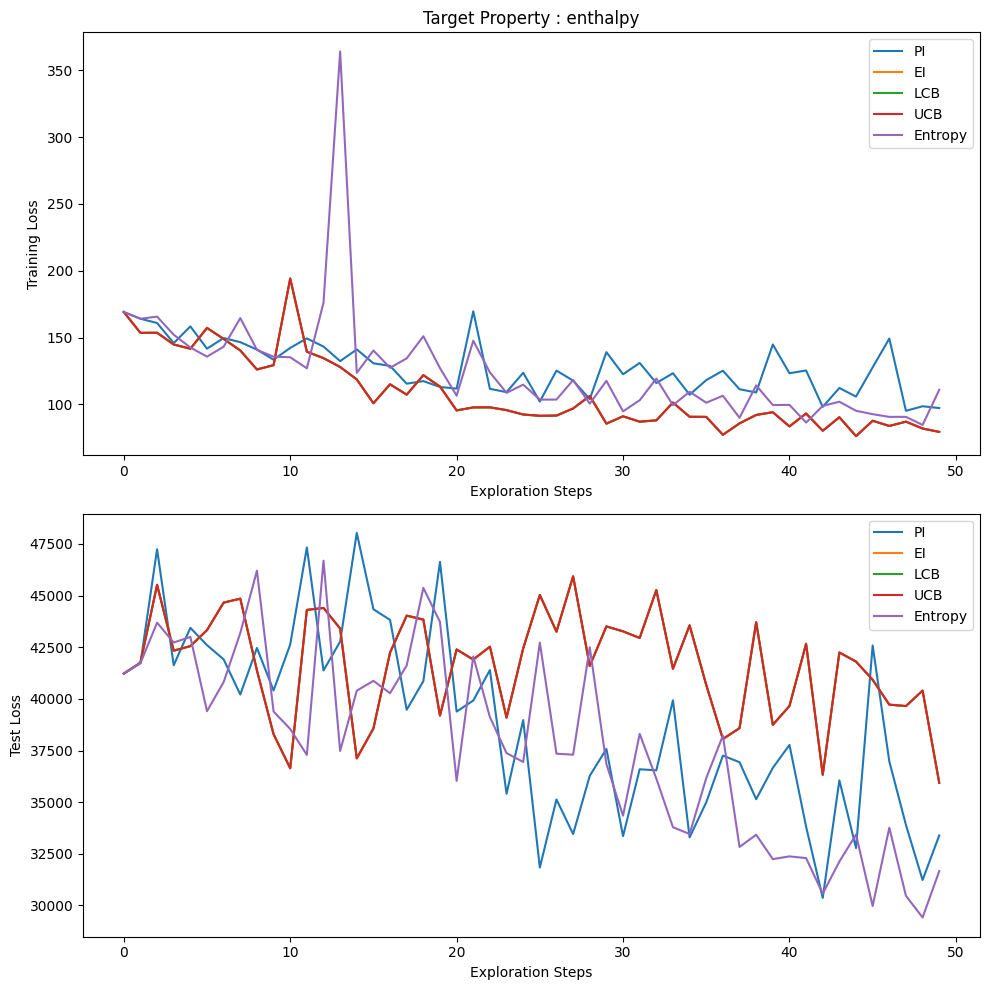

In [15]:
import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))


for acq in acquisition_functions:
    train_loss = train_loss_dict[acq]
    test_loss = test_loss_dict[acq]
   

    # Plot Training Loss
    axs[0].plot(train_loss, label=f'{acq}') 
    axs[0].legend()
    
    # Plot Test Loss
    axs[1].plot(test_loss, label=f'{acq}')
    axs[1].legend()
    
   

axs[0].set_title(f'Target Property : {target_property}')
axs[0].set_xlabel('Exploration Steps')
axs[0].set_ylabel('Training Loss')

# axs[1].set_title('Test Loss')
axs[1].set_xlabel('Exploration Steps')
axs[1].set_ylabel('Test Loss')



plt.tight_layout()
plt.show()


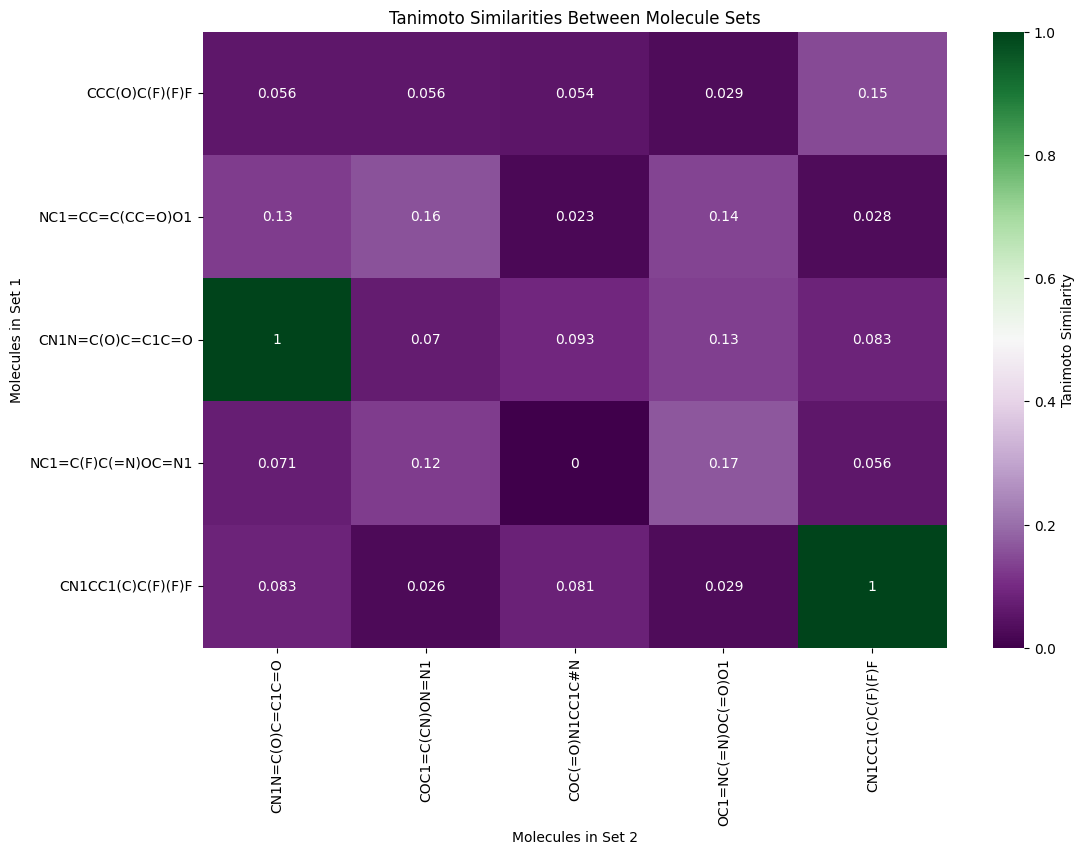

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

# Function to calculate molecular fingerprints
def calculate_fingerprint(smiles_list):
    mol_list = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    # Annotate molecules with numbers corresponding to their order
    for i, mol in enumerate(mol_list):
        if mol is not None:
            mol.SetProp("_Name", str(i+1))
    
    fingerprint_list = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
    return fingerprint_list

# Calculate fingerprints for each set
fingerprint_set1 = calculate_fingerprint(molecules["Entropy"])
fingerprint_set2 = calculate_fingerprint(molecules["LCB"])

# Calculate Tanimoto similarities
similarities = [[TanimotoSimilarity(fp1, fp2) for fp2 in fingerprint_set2] for fp1 in fingerprint_set1]

# Average Tanimoto similarity for each molecule in set1
avg_similarities_set1 = [sum(similarities[i]) / len(molecules["LCB"]) for i in range(len(molecules["Entropy"]))]

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(
    np.array(similarities),
    cmap="PRGn",
    annot=True,
    xticklabels=molecules["LCB"],
    yticklabels=molecules["Entropy"],
    cbar_kws={'label': 'Tanimoto Similarity'}
)

# Set plot labels and title
plt.xlabel('Molecules in Set 2')
plt.ylabel('Molecules in Set 1')
plt.title('Tanimoto Similarities Between Molecule Sets')

# Show the plot
plt.show()



Train with Acquisition Function Entorpy in `DemoP1.ipynb` and continue training with CMF logged artifacts in `DemoP2.ipynb`